<a href="https://colab.research.google.com/github/hollimey/capstone-application/blob/main/OceanWeatherApp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Get User Location Input

In [ ]:
# get user location input (U.S. only)

user_location = input("Enter a U.S. location to get weather information (ex. Seattle, WA): ")

#### Convert to Coords

In [ ]:
# use geocoding library to convert city name into lat and lon coordinates

%pip install geopy

from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut, GeocoderUnavailable

geolocator = Nominatim(user_agent="weather_app")

try:
    user_location_geocoded = geolocator.geocode(user_location)
    if user_location_geocoded:
        latitude = user_location_geocoded.latitude
        longitude = user_location_geocoded.longitude
        print(f"Latitude: {latitude}, Longitude: {longitude}")
    else:
        print(f"Location '{user_location}' not found.")
        latitude = None
        longitude = None
except (GeocoderTimedOut, GeocoderUnavailable) as e:
    print(f"Geocoding service error: {e}")
    latitude = None
    longitude = None

Note: you may need to restart the kernel to use updated packages.
Latitude: 47.6038321, Longitude: -122.330062


### NOAA Weather API Data

In [ ]:
# fetch NOAA weather data from API

import requests
import json

def fetch_weather_data(latitude, longitude):
    point_url = f"https://api.weather.gov/points/{latitude},{longitude}"
    try:
        response = requests.get(point_url)
        response.raise_for_status()  # http error for bad responses
        point_data = response.json()

        forecast_url = point_data['properties']['forecast']
        hourly_forecast_url = point_data['properties']['forecastHourly']
        gridpoints_url = f"https://api.weather.gov/gridpoints/{point_data['properties']['gridId']}/{point_data['properties']['gridX']},{point_data['properties']['gridY']}/forecast"

        # fetch forecast data
        forecast_response = requests.get(forecast_url)
        forecast_response.raise_for_status()
        forecast_data = forecast_response.json()

        # fetch hourly forecast data
        hourly_forecast_response = requests.get(hourly_forecast_url)
        hourly_forecast_response.raise_for_status()
        hourly_forecast_data = hourly_forecast_response.json()

        # fetch gridpoints data
        gridpoints_response = requests.get(gridpoints_url)
        gridpoints_response.raise_for_status()
        gridpoints_data = gridpoints_response.json()

        # return dictionary containing point, forecasts, and gridpoints, or None if error occurs
        return {
            "point_data": point_data,
            "forecast": forecast_data,
            "hourly_forecast": hourly_forecast_data,
            "gridpoints": gridpoints_data
        }
    except requests.exceptions.RequestException as e:
        print(f"Error fetching weather data: {e}")
        return None

# check if lat and lon are available; call fetch_weather_data function if so
weather_data_result = None
if latitude is not None and longitude is not None:
    weather_data_result = fetch_weather_data(latitude, longitude)
    if weather_data_result:
        print("Weather data fetched successfully.")
    else:
        print("Failed to fetch weather data.")
else:
    print("Cannot fetch weather data due to geocoding failure.")

# determine the state for which to fetch alerts
state_code = None
if weather_data_result and 'point_data' in weather_data_result and \
   'properties' in weather_data_result['point_data'] and \
   'relativeLocation' in weather_data_result['point_data']['properties'] and \
   'properties' in weather_data_result['point_data']['properties']['relativeLocation'] and \
   'state' in weather_data_result['point_data']['properties']['relativeLocation']['properties']:
    state_code = weather_data_result['point_data']['properties']['relativeLocation']['properties']['state']
    print(f"Determined state for alerts: {state_code}")
else:
    print("Could not determine state for fetching alerts.")

# fetch and parse alerts if state_code is available
parsed_alerts = [] # initialize parsed_alerts to an empty list
if state_code:
    # construct the URL for fetching active weather alerts
    alerts_url = f"https://api.weather.gov/alerts/active?area={state_code}"
    print(f"\nFetching alerts from: {alerts_url}")

    # make an HTTP GET request to the alerts URL
    try:
        alerts_response = requests.get(alerts_url)

        # check if the response status code indicates success
        if alerts_response.status_code == 200:
            # parse the JSON response
            weather_alerts_data = alerts_response.json()
            print("Weather alerts data fetched successfully.")

            # parse the JSON response from the alerts API
            if weather_alerts_data and 'features' in weather_alerts_data:
                for feature in weather_alerts_data['features']:
                    if 'properties' in feature:
                        properties = feature['properties']
                        alert_info = {
                            'event': properties.get('event'),
                            'headline': properties.get('headline'),
                            'description': properties.get('description'),
                            'effective': properties.get('effective'),
                            'expires': properties.get('expires')
                        }
                        parsed_alerts.append(alert_info)
            print(f"Parsed {len(parsed_alerts)} active alerts.")
        else:
            print(f"Error fetching weather alerts: Status code {alerts_response.status_code}")
            weather_alerts_data = None
    except requests.exceptions.RequestException as e:
        print(f"Error during weather alerts request: {e}")
        weather_alerts_data = None
else:
    print("State code/abbreviation not available. Cannot fetch weather alerts.")
    weather_alerts_data = None


# save data structure to JSON file
if weather_data_result:
    weather_output = {
        "weather_data": weather_data_result,
        "weather_alerts": parsed_alerts
    }
    weather_file = "noaa_atmos_data.json"
    try:
        with open(weather_file, 'w') as f:
            json.dump(weather_output, f, indent=4)
        print(f"\nWeather data and alerts saved to {weather_file}")
    except Exception as e:
        print(f"\nError saving weather data and alerts to JSON: {e}")
else:
    print("Weather data has not been fetched yet.\n")


Weather data fetched successfully.
Determined state for alerts: WA

Fetching alerts from: https://api.weather.gov/alerts/active?area=WA
Weather alerts data fetched successfully.
Parsed 14 active alerts.

Weather data and alerts saved to noaa_atmos_data.json


### EPA Air Quality API Data

In [ ]:
# fetch AQ data from EPA API

import requests
import json

# NOTE: add a secure method for handling API keys
airnow_api_key = "17C7530F-6ED9-40D5-8DA3-A8328CB8F1B0"
airnow_url = f"https://www.airnowapi.org/aq/observation/latLong/current/?format=application/json&latitude={latitude}&longitude={longitude}&distance=25&API_KEY={airnow_api_key}"

try:
    response = requests.get(airnow_url)
    response.raise_for_status()  # raise an HTTPError for bad responses
    aq_data = response.json()
    print("Air quality data fetched successfully.")
except requests.exceptions.RequestException as e:
    print(f"Error fetching air quality data: {e}")
    aq_data = None

# save data structure to JSON file
if aq_data:
    # specify the filename for the JSON file
    aq_file = "epa_aq_data.json"
    try:
        # write the air quality data to a JSON file
        with open(aq_file, 'w') as f:
            json.dump(aq_data, f, indent=4)
        print(f"\nAir quality data saved to {aq_file}")
    except Exception as e:
        print(f"Error saving air quality data to JSON: {e}")
else:
    print("Air quality data not available to save.")

Air quality data fetched successfully.

Air quality data saved to epa_aq_data.json


### NOAA Buoy TXT Data

In [ ]:
# fetch and parse ocean data

import requests
import pandas as pd
from io import StringIO
import json

# buoy data text file
buoy_url = "https://www.ndbc.noaa.gov/data/latest_obs/latest_obs.txt"

try:
  response = requests.get(buoy_url)
  response.raise_for_status()
  text_content = response.text

  # parse the text content into a pandas DataFrame
  # the data seems to be space-separated with a header row starting with '#'
  # we need to skip the comment lines at the beginning
  data_lines = text_content.strip().split('\n')
  # find the actual header row (usually starts with #)
  header_line_index = -1
  for i, line in enumerate(data_lines):
      if line.startswith('#'):
          header_line_index = i
          break

  if header_line_index != -1:
      # use StringIO to treat the string as a file and read with pandas
      # skip the initial comment lines and use the identified header
      buoy_dataframe = pd.read_csv(StringIO('\n'.join(data_lines[header_line_index:])), sep='\s+', skiprows=[1]) # skip the units row
      print("Ocean data fetched and parsed successfully.")

      # metadata for the parameters
      parameter_metadata = {
          "WDIR": "Wind Direction (degT)",
          "WSPD": "Wind Speed (m/s)",
          "GST": "Wind Gust (m/s)",
          "WVHT": "Wave Height (m)",
          "DPD": "Dominant Wave Period (sec)",
          "APD": "Average Wave Period (sec)",
          "MWD": "Mean Wave Direction (degT)",
          "PRES": "Atmospheric Pressure (hPa)",
          "PTDY": "Pressure Tendency (hPa)",
          "ATMP": "Air Temperature (degC)",
          "WTMP": "Water Temperature (degC)",
          "DEWP": "Dewpoint Temperature (degC)",
          "VIS": "Visibility (nmi)",
          "TIDE": "Tide (ft)"
      }

      # save data to JSON file
      ocean_buoy_file = "noaa_buoy_data.json"
      try:
          # convert dataframe to a list of dictionaries for JSON serialization
          buoy_data_list = buoy_dataframe.to_dict(orient='records')

          # combine metadata and data
          output_data = {
              "metadata": parameter_metadata,
              "data": buoy_data_list
          }

          with open(ocean_buoy_file, 'w') as f:
              json.dump(output_data, f, indent=4)
          print(f"\nNOAA buoy data saved to {ocean_buoy_file}")
      except Exception as e:
          print(f"\nError saving NOAA buoy data to JSON: {e}")
  else:
      print("Could not find header line in NOAA buoy data.")
      buoy_dataframe = None

except requests.exceptions.RequestException as e:
    print(f"Error fetching NOAA buoy data: {e}")
    buoy_dataframe = None
except Exception as e:
    print(f"Error parsing NOAA buoy data: {e}")
    buoy_dataframe = None

Ocean data fetched and parsed successfully.

NOAA buoy data saved to noaa_buoy_data.json


<>:30: SyntaxWarning: invalid escape sequence '\s'
<>:30: SyntaxWarning: invalid escape sequence '\s'
C:\Users\bmo\AppData\Local\Temp\ipykernel_23692\2938748167.py:30: SyntaxWarning: invalid escape sequence '\s'
  buoy_dataframe = pd.read_csv(StringIO('\n'.join(data_lines[header_line_index:])), sep='\s+', skiprows=[1]) # skip the units row


#### View Data Structure

In [ ]:
# print the first 10 lines to inspect the format
try:
  print('\n'.join(text_content.strip().split('\n')[:10]))

except requests.exceptions.RequestException as e:
  print(f"Error fetching NOAA buoy data: {e}")

#STN       LAT      LON  YYYY MM DD hh mm WDIR WSPD   GST WVHT  DPD APD MWD   PRES  PTDY  ATMP  WTMP  DEWP  VIS   TIDE
#text      deg      deg   yr mo day hr mn degT  m/s   m/s   m   sec sec degT   hPa   hPa  degC  degC  degC  nmi     ft
22101    37.24   126.02  2025 08 12 21 00 170   8.0    MM  0.0   6   MM  MM     MM    MM  24.7  24.7    MM   MM     MM
22102    34.79   125.78  2025 08 12 21 00 160   5.0    MM  0.5   7   MM  MM     MM    MM  23.4  22.9    MM   MM     MM
22103    34.00   127.50  2025 08 12 21 00 200   5.0    MM  1.0  12   MM  MM     MM    MM  27.5  27.0    MM   MM     MM
22104    34.77   128.90  2025 08 12 21 00  40   0.0    MM  0.5   7   MM  MM     MM    MM  25.8  27.4    MM   MM     MM
22105    37.54   130.00  2025 08 12 21 00 160   6.0    MM  0.0   0   MM  MM     MM    MM  27.7  26.1    MM   MM     MM
22106    36.35   129.78  2025 08 12 21 00 200   4.0    MM  0.5   6   MM  MM     MM    MM  26.1  26.9    MM   MM     MM
22107    33.08   126.03  2025 08 12 21 00 180   

#### Find Nearest Stations


In [ ]:
from geopy.distance import geodesic
import pandas as pd

# error message if no user location found
if latitude is None or longitude is None:
    print("User location could not be determined.")
    buoy_dataframe = None

# calculate the distance between user and each buoy station
if buoy_dataframe is not None:
    def calculate_distance(row):
        station_lat = pd.to_numeric(row['LAT'], errors='coerce')
        station_lon = pd.to_numeric(row['LON'], errors='coerce')

        if pd.isna(station_lat) or pd.isna(station_lon):
            return float('inf')
        try:
            user_coords = (latitude, longitude)
            station_coords = (station_lat, station_lon)
            return geodesic(user_coords, station_coords).miles
        except ValueError:
            return float('inf')

    buoy_dataframe['Distance'] = buoy_dataframe.apply(calculate_distance, axis=1)
    print("Distance to user location calculated for each station.")

    # sort by distance
    nearest_stations_df = buoy_dataframe.sort_values(by='Distance').reset_index(drop=True)

    # update to use correct column names based on the first row
    requested_parameters = {
        'WDIR': 'WDIR', 'WSPD': 'WSPD', 'GST': 'GST', 'WVHT': 'WVHT',
        'DPD': 'DPD', 'APD': 'APD', 'MWD': 'MWD', 'PRES': 'PRES',
        'PTDY': 'PTDY', 'ATMP': 'ATMP', 'WTMP': 'WTMP', 'DEWP': 'DEWP', 'VIS': 'VIS', 'TIDE': 'TIDE'
    }

    extracted_data = {} # initialize data
    parameters_found = { # track which parameters are found
        param: False for param in requested_parameters.keys()
        }
    searched_stations = [] # list to store info about searched stations

    # iterate through stations, starting from the nearest
    for index, station in nearest_stations_df.iterrows():
        station_id = station['#STN'] # use '#STN' as column name
        station_distance = station['Distance']

        # check if the station is within the 80 miles
        if station_distance <= 80:
            searched_stations.append({'id': station_id, 'distance': station_distance}) # store station info

            # flag to check if all requested parameters are found
            all_found_for_this_station = True

            for param_name, col_name in requested_parameters.items():
                if not parameters_found[param_name]:
                    param_value = station.get(col_name)

                    if pd.notna(param_value) and str(param_value).strip().upper() != 'MM':
                        extracted_data[param_name] = {
                            'value': param_value,
                            'station_id': station_id,
                            'distance_miles': station_distance
                            }
                        parameters_found[param_name] = True
                    else:
                       all_found_for_this_station = False # if missing parameter

            if all(parameters_found.values()):
                print("\nAll requested parameters found within the 80-mile radius.")
                break # exit the loop once all parameters are found
        else:
            # stop searching once we exceed the 80-mile radius
            print(f"\nSearch radius set to: <= 80 miles.")
            break

    if not all(parameters_found.values()):
        missing_params = [param for param, found in parameters_found.items() if not found]
        print(f"\nCould not find data for the following parameters from available stations within the 80-mile radius: {', '.join(missing_params)}.")

    # display results
    print("\n------ Buoy data from nearest station(s) ------")
    if extracted_data:
        for param, data in extracted_data.items():
            print(f"{param}: {data['value']} (from station {data['station_id']}, {data['distance_miles']:.2f} miles away)")
    else:
        print("No buoy data could be extracted for the requested parameters within the 80-mile radius.")

    print("\n---- All stations searched within 80 miles ----")
    if searched_stations:
        for station_info in searched_stations:
            print(f"Station ID: {station_info['id']}, Distance: {station_info['distance']:.2f} miles")
    else:
        print("No stations within the 80-mile radius were searched.")

else:
    print("Buoy data is not available to extract data.")

Distance to user location calculated for each station.

Search radius set to: <= 80 miles.

Could not find data for the following parameters from available stations within the 80-mile radius: WVHT, DPD, APD, MWD, VIS, TIDE.

------ Buoy data from nearest station(s) ------
WDIR: 320 (from station WPOW1, 6.34 miles away)
WSPD: 1.0 (from station WPOW1, 6.34 miles away)
GST: 1.0 (from station WPOW1, 6.34 miles away)
PRES: 1012.8 (from station WPOW1, 6.34 miles away)
PTDY: -1.1 (from station WPOW1, 6.34 miles away)
ATMP: 23.5 (from station WPOW1, 6.34 miles away)
DEWP: 15.5 (from station WPOW1, 6.34 miles away)
WTMP: 14.0 (from station TCNW1, 23.59 miles away)

---- All stations searched within 80 miles ----
Station ID: WPOW1, Distance: 6.34 miles
Station ID: 46120, Distance: 11.30 miles
Station ID: BMTW1, Distance: 14.13 miles
Station ID: TCMW1, Distance: 23.02 miles
Station ID: TCNW1, Distance: 23.59 miles
Station ID: 46121, Distance: 29.19 miles
Station ID: 46123, Distance: 35.46 miles
S

### CO-OPS XML Data

In [ ]:
# list of active National Water Level Observation Network (NWLON) stations
# active water level/met stations (and sensor configurations)
# source: https://opendap.co-ops.nos.noaa.gov/stations/index.jsp

import requests
import xml.etree.ElementTree as ET

# excel file of stations and their coordinates
coops_url = "https://opendap.co-ops.nos.noaa.gov/stations/stationsXML.jsp"

# fetch station data
try:
    response = requests.get(coops_url)
    response.raise_for_status()  # http error for bad responses (4xx or 5xx)
    coops_text_content = response.text
    print("CO-OPS station data fetched successfully.")
except requests.exceptions.RequestException as e:
    print(f"Error fetching CO-OPS station data: {e}")
    coops_text_content = None

# parse the excel file to extract station info
if coops_text_content:
    try:
        # register the namespace to properly find elements
        namespace = {'coops': 'https://stations-prod.co-ops-aws-east1.net/stations/'}
        root = ET.fromstring(coops_text_content)
        print("XML content parsed successfully.")

        coops_stations_data = []
        # find all 'station' elements using the registered namespace
        for station in root.findall('coops:station', namespace):
            station_id = station.get('ID')
            name = station.get('name')

            # find the 'location' element within the 'metadata'
            location_element = station.find('.//coops:location', namespace)

            if location_element is not None:
                latitude_element = location_element.find('coops:lat', namespace)
                longitude_element = location_element.find('coops:long', namespace)

                if station_id and name and latitude_element is not None and longitude_element is not None:
                    try:
                        latitude = float(latitude_element.text)
                        longitude = float(longitude_element.text)
                        coops_stations_data.append({
                            'id': station_id,
                            'name': name,
                            'latitude': latitude,
                            'longitude': longitude
                        })
                    except ValueError:
                        print(f"Could not convert coordinates to float for station {station_id}")
        print(f"Extracted data for {len(coops_stations_data)} stations.")
    except ET.ParseError as e:
        print(f"Error parsing XML: {e}")
        coops_stations_data = None
else:
    print("No data available to parse.")
    coops_stations_data = None

CO-OPS station data fetched successfully.
XML content parsed successfully.
Extracted data for 381 stations.


#### View Data Structure

In [ ]:
# view file structure
if coops_text_content:
    # print first 20 lines
    print('\n'.join(coops_text_content.strip().split('\n')[:20]))
else:
    print("No CO-OPS data available to inspect.")

<?xml version="1.0" encoding="ISO-8859-1" ?>
<stations xmlns="https://stations-prod.co-ops-aws-east1.net/stations/" 
xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" 
xsi:schemaLocation="https://stations-prod.co-ops-aws-east1.net/stations/xml_schemas/stations.xsd"> 
<station name="Nawiliwili" ID="1611400" >
<metadata>
<location>
<lat>21.9544</lat>
<long>-159.3561</long>
<state>HI</state>
</location>
<date_established>1954-11-24</date_established>
</metadata>
<parameter name="Water Level" sensorID="A1" DCP="1" status="1" />
<parameter name="Winds" sensorID="C1" DCP="3" status="1" />
<parameter name="Air Temp" sensorID="D1" DCP="3" status="1" />
<parameter name="Water Temp" sensorID="E1" DCP="1" status="1" />
<parameter name="Air Pressure" sensorID="F1" DCP="3" status="1" />
<parameter name="" sensorID="U1" DCP="1" status="1" />
</station>


#### Find Nearest Station FIX


In [ ]:
from geopy.distance import geodesic

# find nearest stations
if latitude is None or longitude is None:
    print("User location (latitude or longitude) not available. Skipping distance calculation.")
elif 'coops_stations_data' not in globals() or not coops_stations_data:
    print("CO-OPS stations data not available. Skipping distance calculation.")
else:
    # iterate through coops_stations_data list
    for station in coops_stations_data:
        # extract latitude and longitude for each station
        station_lat = station.get('latitude')
        station_lon = station.get('longitude')

        # calculate distance
        if station_lat is not None and station_lon is not None:
            try:
                user_coords = (latitude, longitude)
                station_coords = (station_lat, station_lon)
                distance = geodesic(user_coords, station_coords).miles
            except ValueError:
                # handle potential value error during calculation
                distance = float('inf')
        else:
            distance = float('inf') # assign infinity if coords are missing

        # add a 'distance' key to each station's dictionary
        station['distance'] = distance
    print("Distance to each CO-OPS station calculated.")

# find station with shortest distance to user
if 'coops_stations_data' not in globals() or not coops_stations_data:
    print("CO-OPS station data not available. Cannot find the nearest station.")
else:
    try:
        nearest_coops_station = min(coops_stations_data, key=lambda station: station.get('distance', float('inf')))

        # print the ID, name, and distance of the nearest station
        station_id = nearest_coops_station.get('id', 'N/A')
        station_name = nearest_coops_station.get('name', 'N/A')
        station_distance = nearest_coops_station.get('distance', float('inf'))

        if station_distance != float('inf'):
            print(f"\n------- Nearest CO-OPS station ------- \nStation ID: {station_id}, name: {station_name}, distance: {station_distance:.2f} miles")
        else:
            print("Nearest CO-OPS station found, but distance information is missing.")
    except ValueError:
        print("Could not find the nearest CO-OPS station.")

Distance to each CO-OPS station calculated.

------- Nearest CO-OPS station ------- 
Station ID: 9759938, name: Mona Island, distance: 0.00 miles


#### Fetch Station Observations


In [ ]:
# fetch water level data
if 'nearest_coops_station' not in globals() or not nearest_coops_station or 'id' not in nearest_coops_station:
    print("Nearest CO-OPS station information is not available. Cannot fetch data.")
    coops_data_text = None # for if station info is missing
else:
    station_id_num = nearest_coops_station['id']

    parameters = { # parameter dictionary and their 'p' values
        'water_level': 0,
        'water_temp': 1,
        'air_temp': 2,
        'air_pressure': 3,
        'winds': 4,
        'conductivity': 5,
        'humidity': 6,
        'air_gap': 7,
        'visibility': 8
    }

    coops_data_text = {} # dictionary to store data for each parameter

    for param_name, p_value in parameters.items():
        # construct the API URL for fetching data
        coops_url = f"https://opendap.co-ops.nos.noaa.gov/stations/data/getdata.jsp?p={p_value}&id={station_id_num}"

        print(f"\nFetching {param_name} data from: {coops_url}")
        try:
            # make http request to the API URL
            response = requests.get(coops_url)

            # check if request was successful
            if response.status_code == 200:
                # if so store response text content in the dictionary
                coops_data_text[param_name] = response.text
                print(f"{param_name} data fetched successfully.")
            else:
                print(f"Error fetching {param_name} data: Status code {response.status_code}") # error message if unsuccessful
                coops_data_text[param_name] = None
        except requests.exceptions.RequestException as e:
            print(f"Error during {param_name} data request: {e}")
            coops_data_text[param_name] = None


Fetching water_level data from: https://opendap.co-ops.nos.noaa.gov/stations/data/getdata.jsp?p=0&id=9759938
water_level data fetched successfully.

Fetching water_temp data from: https://opendap.co-ops.nos.noaa.gov/stations/data/getdata.jsp?p=1&id=9759938
water_temp data fetched successfully.

Fetching air_temp data from: https://opendap.co-ops.nos.noaa.gov/stations/data/getdata.jsp?p=2&id=9759938
air_temp data fetched successfully.

Fetching air_pressure data from: https://opendap.co-ops.nos.noaa.gov/stations/data/getdata.jsp?p=3&id=9759938
air_pressure data fetched successfully.

Fetching winds data from: https://opendap.co-ops.nos.noaa.gov/stations/data/getdata.jsp?p=4&id=9759938
winds data fetched successfully.

Fetching conductivity data from: https://opendap.co-ops.nos.noaa.gov/stations/data/getdata.jsp?p=5&id=9759938
conductivity data fetched successfully.

Fetching humidity data from: https://opendap.co-ops.nos.noaa.gov/stations/data/getdata.jsp?p=6&id=9759938
humidity data f

### NOAA Sensor XML Data

In [ ]:
# metadata sources:
# https://tidesandcurrents.noaa.gov/cdata/StationList?type=Current+Data&filter=active
# https://tidesandcurrents.noaa.gov/cdata/StationList?type=Current+Data&filter=historic
# https://tidesandcurrents.noaa.gov/waterlevels.html?id=9447130
# These raw data have not been subjected to the National Ocean Service's quality control or quality assurance procedures and do not meet the criteria and standards of official National Ocean Service data. They are released for limited public use as preliminary data to be used only with appropriate caution.

import pandas as pd
import json

# embed station data
active_stations_filename = "/coops-activecurrentstations.csv"
try:
    active_stations_df = pd.read_csv(active_stations_filename)
    # convert df to JSON string
    active_stations_json = active_stations_df.to_json(orient='records')
    print(f"Successfully loaded and embedded {active_stations_filename}")
except FileNotFoundError:
    print(f"Error: {active_stations_filename} not found. Please ensure the file exists.")
    active_stations_json = None
except Exception as e:
    print(f"An unexpected error occurred while processing {active_stations_filename}: {e}")
    active_stations_json = None

historic_stations_filename = "/coops-historiccurrentstations.csv"
try:
    historic_stations_df = pd.read_csv(historic_stations_filename)
    historic_stations_json = historic_stations_df.to_json(orient='records')
    print(f"Successfully loaded and embedded {historic_stations_filename}")
except FileNotFoundError:
    print(f"Error: {historic_stations_filename} not found. Please ensure the file exists.")
    historic_stations_json = None
except Exception as e:
    print(f"An unexpected error occurred while processing {historic_stations_filename}: {e}")
    historic_stations_json = None

# now use CO-OPS sensor API to retrieve observations and predictions from CO-OPS stations listed here
# source: https://api.tidesandcurrents.noaa.gov/api/prod/#requestResponse

Error: /coops-activecurrentstations.csv not found. Please ensure the file exists.
Error: /coops-historiccurrentstations.csv not found. Please ensure the file exists.


#### Tide Predictions

In [ ]:
# metadata sources:
# https://tidesandcurrents.noaa.gov/education/tech-assist/training/user-guides/assets/pdfs/Tide_Predictions_User_Guide_v4.pdf
# https://tidesandcurrents.noaa.gov/water_level_info.html

import requests
import json
from datetime import datetime, timedelta

# fetch tide predictions from the CO-OPS API
if 'nearest_coops_station' not in globals() or not nearest_coops_station or 'id' not in nearest_coops_station:
    print("Nearest CO-OPS station information is not available. Cannot fetch tide predictions.")

else:
    station_id_num = nearest_coops_station['id']

    # define the date range
    today = datetime.now().strftime('%Y%m%d')
    yesterday = (datetime.now() - timedelta(days=1)).strftime('%Y%m%d')

    # construct the API URL
    tide_predictions_url = f"https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?product=predictions&application=NOS.COOPS.TAC.WL&begin_date={yesterday}&end_date={today}&datum=MLLW&station={station_id_num}&time_zone=GMT&units=english&interval=&format=json"
    print(f"Fetching tide predictions from: {tide_predictions_url}")

    try:
        # make an http request to the API URL
        response = requests.get(tide_predictions_url)

        # check if request was successful
        if response.status_code == 200:
            # parse the JSON response
            tide_predictions_data = response.json()
            print("Tide predictions data fetched successfully.")
        else:
            print(f"Error fetching tide predictions: Status code {response.status_code}")
            tide_predictions_data = None
    except requests.exceptions.RequestException as e:
        print(f"Error during tide predictions request: {e}")
        tide_predictions_data = None

Fetching tide predictions from: https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?product=predictions&application=NOS.COOPS.TAC.WL&begin_date=20250811&end_date=20250812&datum=MLLW&station=9759938&time_zone=GMT&units=english&interval=&format=json
Tide predictions data fetched successfully.


#### Water Levels

In [ ]:
import requests
import json
from datetime import datetime, timedelta

# fetch water level data from the CO-OPS API
if 'nearest_coops_station' not in globals() or not nearest_coops_station or 'id' not in nearest_coops_station:
    print("Nearest CO-OPS station information is not available. Cannot fetch water level data.")
else:
    station_id_num = nearest_coops_station['id']

    # define the date range for the data (yesterday and today)
    today = datetime.now().strftime('%Y%m%d')
    yesterday = (datetime.now() - timedelta(days=1)).strftime('%Y%m%d')

    # construct the API URL
    water_level_url = f"https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?product=water_level&application=NOS.COOPS.TAC.WL&begin_date={yesterday}&end_date={today}&datum=MLLW&station={station_id_num}&time_zone=GMT&units=english&format=json"

    print(f"Fetching water level data from: {water_level_url}")

    try:
        # make an http request to the API URL
        response = requests.get(water_level_url)

        # check if request was successful
        if response.status_code == 200:
            # parse the JSON response
            water_level_data = response.json()
            print("Water level data fetched successfully.")
        else:
            print(f"Error fetching water level data: Status code {response.status_code}")
            water_level_data = None
    except requests.exceptions.RequestException as e:
        print(f"Error during water level data request: {e}")
        water_level_data = None

Fetching water level data from: https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?product=water_level&application=NOS.COOPS.TAC.WL&begin_date=20250811&end_date=20250812&datum=MLLW&station=9759938&time_zone=GMT&units=english&format=json
Water level data fetched successfully.


### TBD

In [ ]:
# currents predictions:
# https://tidesandcurrents.noaa.gov/currents_info.html
# https://tidesandcurrents.noaa.gov/education/tech-assist/training/user-guides/assets/pdfs/Current_Predictions_User_Guide_v5.pdf
# https://tidesandcurrents.noaa.gov/noaacurrents/assets/docs/Tidal_Current_Prediction_Uncertainty.pdf

# PORTS active current stations:
# https://opendap.co-ops.nos.noaa.gov/axis/webservices/activecurrentstations/response.jsp?format=html

# daily maximum and minimum water level (hourly):
# https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?begin_date={yyyymmdd}&end_date={yyyymmdd}&station={station_id_num}&product=daily_max_min&datum=MHHW&time_zone=gmt&units=metric&application=DataAPI_Sample&format=json

# source: https://opendap.co-ops.nos.noaa.gov/ioos-dif-sos/
# SOS sea surface temp: https://opendap.co-ops.nos.noaa.gov/ioos-dif-sos/SOS?service=SOS&request=GetObservation&version=1.0.0&observedProperty=sea_water_temperature&offering=urn:ioos:station:NOAA.NOS.CO-OPS:{station_id}&responseFormat=text/xml;subtype="om/1.0.0/profiles/ioos_sos/1.0"&unit=Fahrenheit

# SOS salinity: https://opendap.co-ops.nos.noaa.gov/ioos-dif-sos/SOS?service=SOS&request=GetObservation&version=1.0.0&observedProperty=sea_water_salinity&offering=urn:ioos:station:NOAA.NOS.CO-OPS:{station_id}&responseFormat=text/xml;subtype="om/1.0.0/profiles/ioos_sos/1.0"

# SOS water surface height (data_types: PreliminaryOneMinute, PreliminarySixMinute): https://opendap.co-ops.nos.noaa.gov/ioos-dif-sos/SOS?service=SOS&request=GetObservation&version=1.0.0&observedProperty=water_surface_height_above_reference_datum&offering=urn:ioos:station:NOAA.NOS.CO-OPS:{station_id}&responseFormat=text/xml;subtype="om/1.0.0/profiles/ioos_sos/1.0"&dataType={data_type}&unit=Meters

# SOS verified (6-min) water surface height: https://opendap.co-ops.nos.noaa.gov/ioos-dif-sos/SOS?service=SOS&request=GetObservation&version=1.0.0&observedProperty=water_surface_height_above_reference_datum&offering=urn:ioos:station:NOAA.NOS.CO-OPS:{station_id}&responseFormat=text/xml;subtype="om/1.0.0/profiles/ioos_sos/1.0"&eventTime={2025-06-01T00:00:00Z}/{2025-06-01T23:59:00Z}&dataType=VerifiedSixMinute&unit=Meters

# SOS verified high/low water surface height: https://opendap.co-ops.nos.noaa.gov/ioos-dif-sos/SOS?service=SOS&request=GetObservation&version=1.0.0&observedProperty=water_surface_height_above_reference_datum&offering=urn:ioos:station:NOAA.NOS.CO-OPS:8454000&responseFormat=text/xml;subtype="om/1.0.0/profiles/ioos_sos/1.0"&eventTime=2025-06-01T00:00:00Z/2025-06-05T23:59:00Z&dataType=VerifiedHighLow&unit=Meters

# CO-OPS SOAP Web Services
# source: https://opendap.co-ops.nos.noaa.gov/axis/

### Weather Visualizations

#### Hourly Graphs

Note: you may need to restart the kernel to use updated packages.


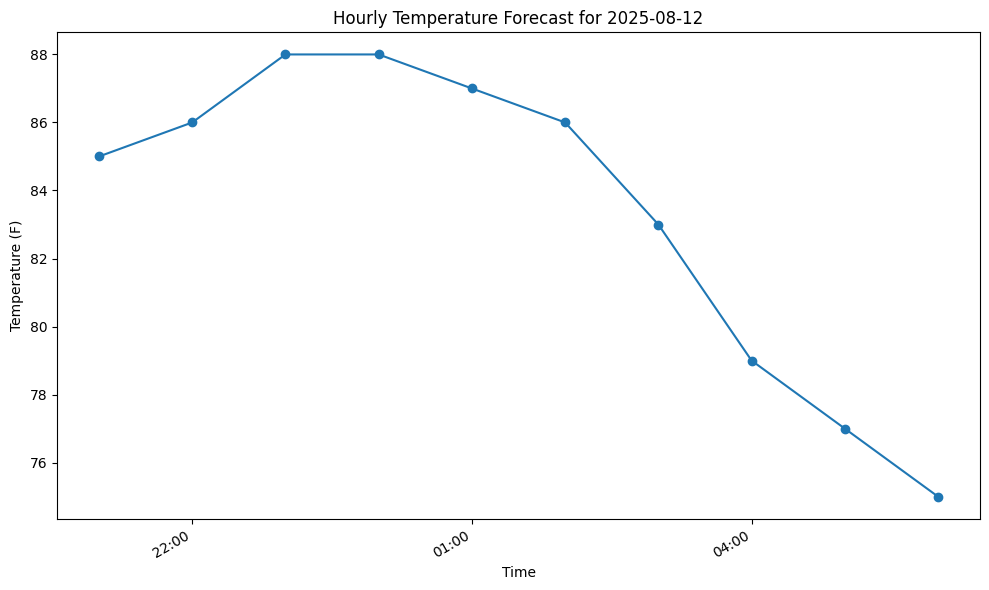

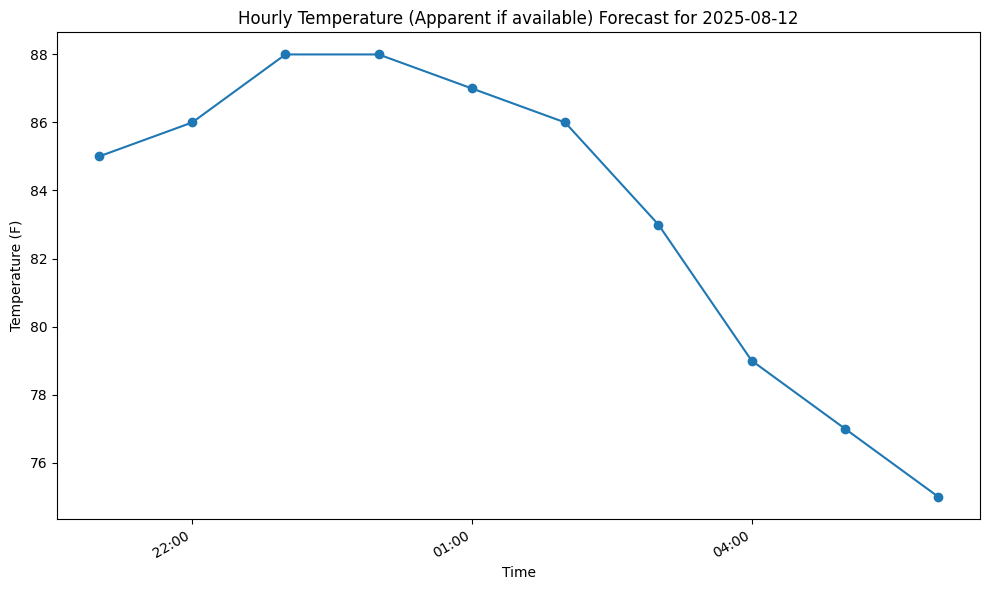

Cloud Cover data not available for visualization for the current date.


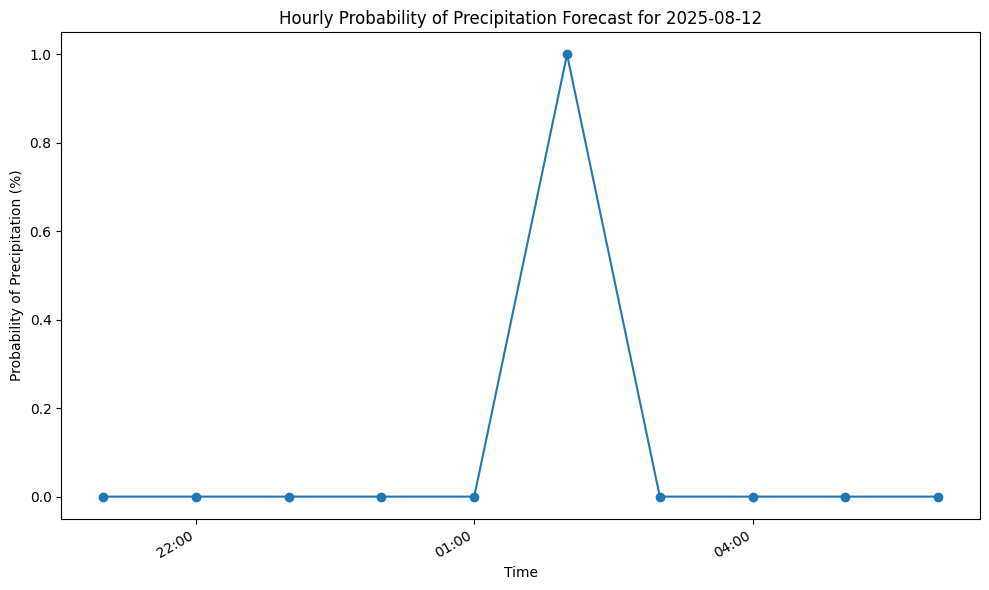

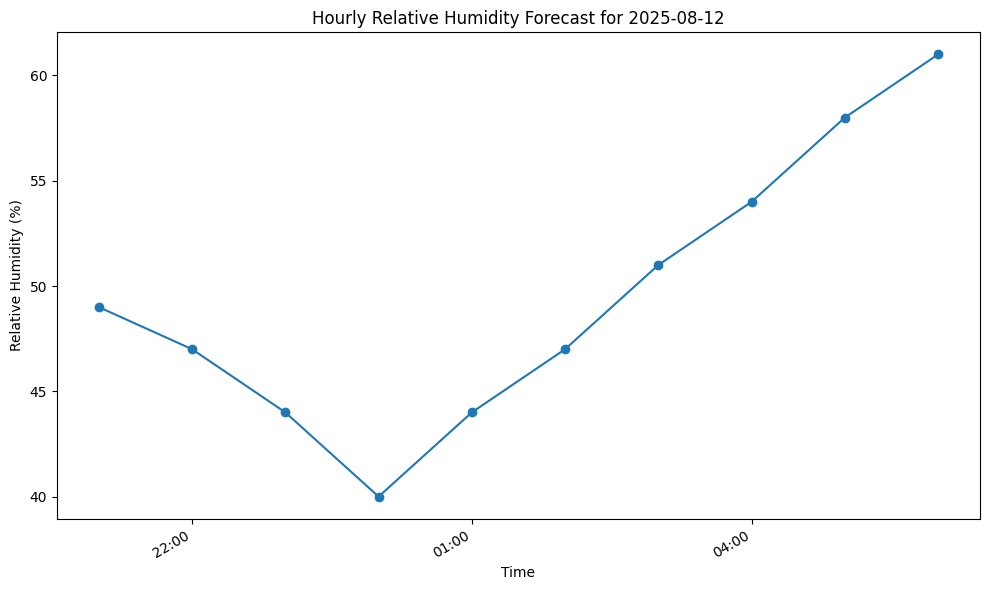

Visibility data not available for visualization for the current date.


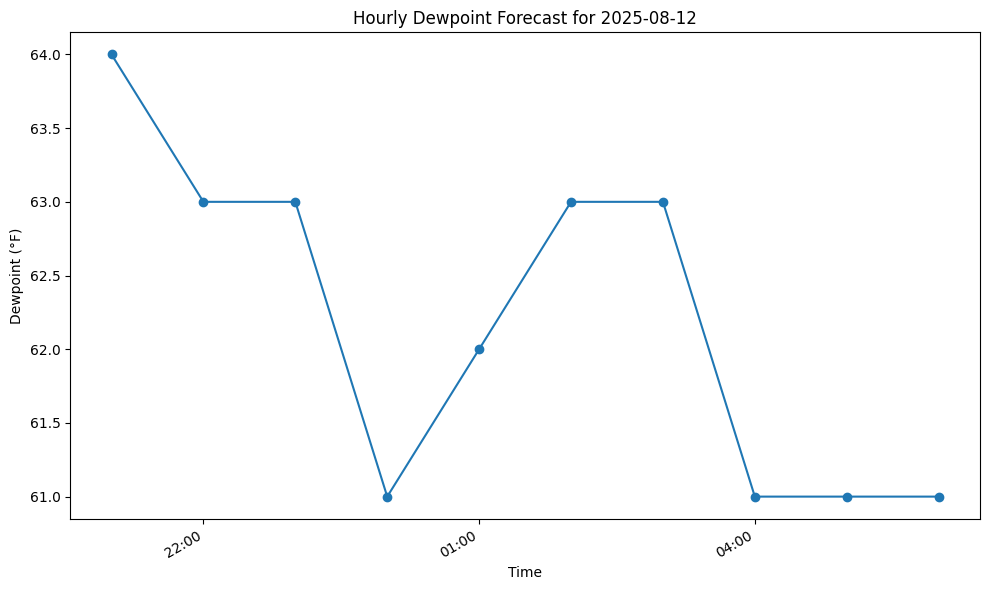

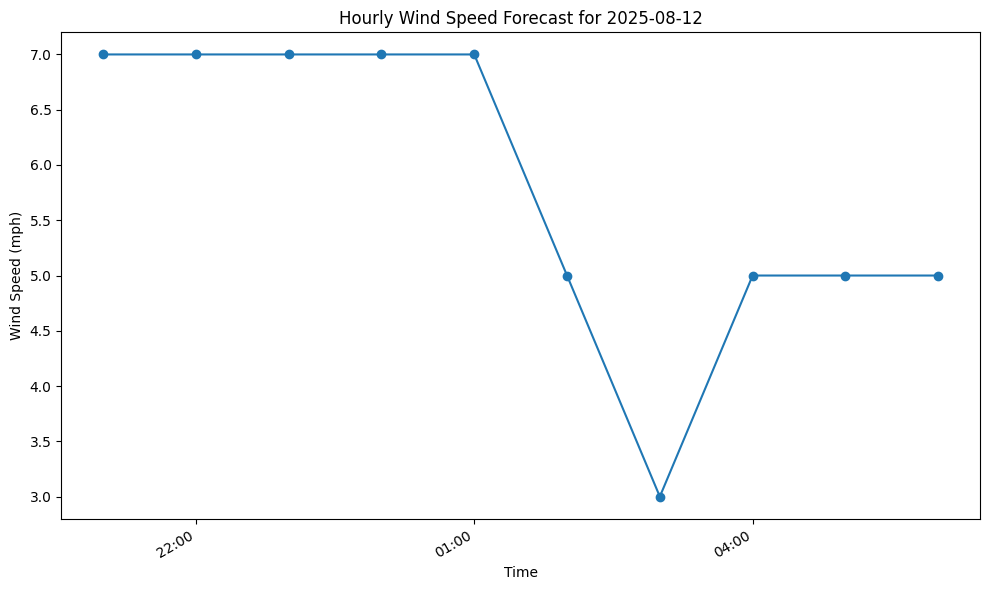

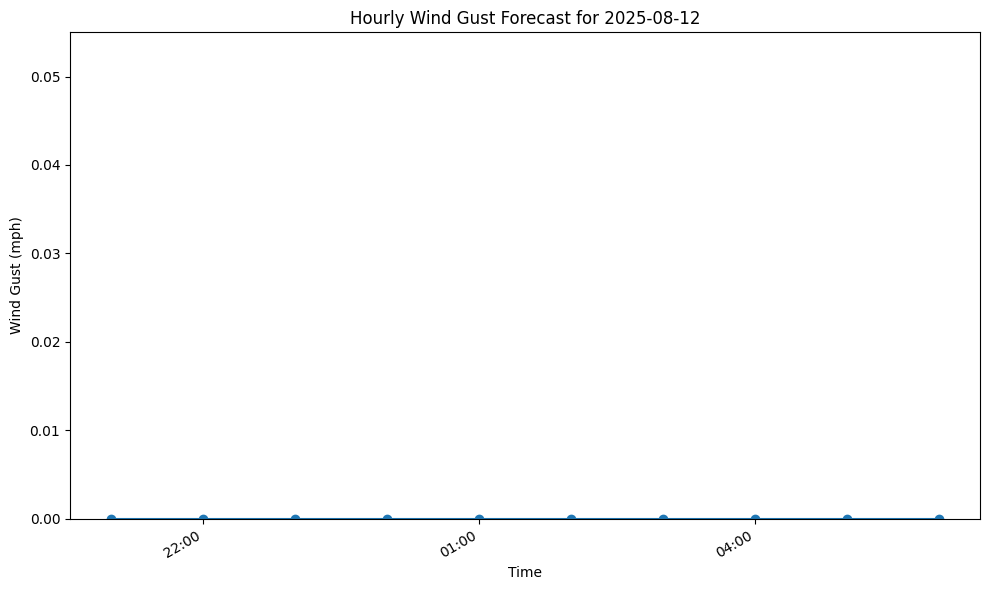

Sky Cover data not available for visualization for the current date.
Heat Index data not available for visualization for the current date.
Snowfall data not available or no snowfall predicted for the current date.
Ice accumulation data not available or no ice accumulation predicted for the current date.


In [ ]:
# hourly temperature forecast line graph -------------------------------------

%pip install matplotlib

import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.dates as mdates
from datetime import date

if weather_data_result and 'hourly_forecast' in weather_data_result:
    hourly_periods = weather_data_result['hourly_forecast']['properties']['periods']

    # filter for the current date
    today = date.today()
    hourly_periods_today = [
        period for period in hourly_periods
        if datetime.fromisoformat(period['startTime']).date() == today
    ]

    if not hourly_periods_today:
        print("No hourly forecast data available for the current date.")
    else:
        times = [datetime.fromisoformat(period['startTime']) for period in hourly_periods_today]
        temperatures = [period['temperature'] for period in hourly_periods_today]

        plt.figure(figsize=(10, 6))
        plt.plot(times, temperatures, marker='o')
        plt.xlabel("Time")
        plt.ylabel(f"Temperature ({hourly_periods_today[0]['temperatureUnit']})")
        plt.title(f"Hourly Temperature Forecast for {today.strftime('%Y-%m-%d')}")

        # format x-axis to show time with appropriate intervals
        ax = plt.gca()
        formatter = mdates.DateFormatter('%H:%M')
        ax.xaxis.set_major_formatter(formatter)

        # format tick locations
        import numpy as np
        hours = mdates.HourLocator(interval=3)  # set a tick every 3 hours
        ax.xaxis.set_major_locator(hours)

        plt.gcf().autofmt_xdate() # auto-format to prevent label overlapping

        plt.tight_layout()
        plt.show()
else:
    print("Hourly forecast data not available for visualization.")



# hourly apparent temperature forecast line graph ----------------------------

if weather_data_result and 'hourly_forecast' in weather_data_result:
    hourly_periods = weather_data_result['hourly_forecast']['properties']['periods']

    today = date.today() # filter for the current date
    hourly_periods_today = [
        period for period in hourly_periods
        if datetime.fromisoformat(period['startTime']).date() == today
    ]

    if not hourly_periods_today:
        print("No hourly forecast data available for the current date.")
    else:
        times = [datetime.fromisoformat(period['startTime']) for period in hourly_periods_today]

        # use apparent temperature if available, otherwise use temperature
        temperatures = []
        for period in hourly_periods_today:
            apparent_temp = period.get('apparentTemperature', {}).get('value')
            if apparent_temp is not None:
                temperatures.append(apparent_temp)
            else:
                temperatures.append(period.get('temperature'))

        # determine the unit
        temp_unit = hourly_periods_today[0].get('temperatureUnit', '')

        plt.figure(figsize=(10, 6))
        plt.plot(times, temperatures, marker='o')
        plt.xlabel("Time")
        plt.ylabel(f"Temperature ({temp_unit})") # label reflects whats plotted
        plt.title(f"Hourly Temperature (Apparent if available) Forecast for {today.strftime('%Y-%m-%d')}")

        # format x-axis to show time with appropriate intervals
        ax = plt.gca()
        formatter = mdates.DateFormatter('%H:%M')
        ax.xaxis.set_major_formatter(formatter)

        # format tick locations
        import numpy as np
        hours = mdates.HourLocator(interval=3)  # set a tick every 3 hours
        ax.xaxis.set_major_locator(hours)

        plt.gcf().autofmt_xdate() # auto-format to prevent label overlapping

        plt.tight_layout()
        plt.show()
else:
    print("Hourly forecast data not available for visualization.")



# hourly cloud cover forecast line graph -------------------------------------

if weather_data_result and 'hourly_forecast' in weather_data_result:
    hourly_periods = weather_data_result['hourly_forecast']['properties']['periods']

    # filter for the current date
    today = date.today()
    hourly_periods_today = [
        period for period in hourly_periods
        if datetime.fromisoformat(period['startTime']).date() == today
    ]

    if not hourly_periods_today:
        print("No hourly forecast data available for the current date.")
    else:
        times = [datetime.fromisoformat(period['startTime']) for period in hourly_periods_today]
        # extract cloud cover - need to handle potential none values
        cloud_cover_values = [period.get('cloudCover', {}).get('value') for period in hourly_periods_today]

        # remove none values for plotting
        times_filtered = [times[i] for i, val in enumerate(cloud_cover_values) if val is not None]
        cloud_cover_values_filtered = [val for val in cloud_cover_values if val is not None]


        if not cloud_cover_values_filtered:
             print("Cloud Cover data not available for visualization for the current date.")
        else:
            plt.figure(figsize=(10, 6))
            plt.plot(times_filtered, cloud_cover_values_filtered, marker='o')
            plt.xlabel("Time")
            plt.ylabel("Cloud Cover (%)")
            plt.title(f"Hourly Cloud Cover Forecast for {today.strftime('%Y-%m-%d')}")

            # format x-axis to show only time and set appropriate intervals
            ax = plt.gca()
            formatter = mdates.DateFormatter('%H:%M')
            ax.xaxis.set_major_formatter(formatter)

            import numpy as np
            hours = mdates.HourLocator(interval=3) # set a tick every 3 hours
            ax.xaxis.set_major_locator(hours)


            plt.gcf().autofmt_xdate() # format to prevent label overlapping

            plt.tight_layout()
            plt.show()
else:
    print("Hourly forecast data not available for visualization.")



# hourly precipitation forecast probability line graph -----------------------

if weather_data_result and 'hourly_forecast' in weather_data_result:
    hourly_periods = weather_data_result['hourly_forecast']['properties']['periods']

    # filter for the current date
    today = date.today()
    hourly_periods_today = [
        period for period in hourly_periods
        if datetime.fromisoformat(period['startTime']).date() == today
    ]

    if not hourly_periods_today:
        print("No hourly forecast data available for the current date.")
    else:
        times = [datetime.fromisoformat(period['startTime']) for period in hourly_periods_today]
        # extract probability of precipitation
        precipitation_probs = [period.get('probabilityOfPrecipitation', {}).get('value', 0) for period in hourly_periods_today]

        plt.figure(figsize=(10, 6))
        plt.plot(times, precipitation_probs, marker='o')
        plt.xlabel("Time")
        plt.ylabel("Probability of Precipitation (%)")
        plt.title(f"Hourly Probability of Precipitation Forecast for {today.strftime('%Y-%m-%d')}")

        # format x-axis to show only time and set appropriate intervals
        ax = plt.gca()
        formatter = mdates.DateFormatter('%H:%M')
        ax.xaxis.set_major_formatter(formatter)

        import numpy as np
        hours = mdates.HourLocator(interval=3)  # set a tick every 3 hours
        ax.xaxis.set_major_locator(hours)


        plt.gcf().autofmt_xdate() # auto-format to prevent labels overlapping

        plt.tight_layout()
        plt.show()
else:
    print("Hourly forecast data not available for visualization.")



# hourly humidity forecast line graph ----------------------------------------

if weather_data_result and 'hourly_forecast' in weather_data_result:
    hourly_periods = weather_data_result['hourly_forecast']['properties']['periods']

    # filter for the current date
    today = date.today()
    hourly_periods_today = [
        period for period in hourly_periods
        if datetime.fromisoformat(period['startTime']).date() == today
    ]

    if not hourly_periods_today:
        print("No hourly forecast data available for the current date.")
    else:
        times = [datetime.fromisoformat(period['startTime']) for period in hourly_periods_today]
        # Extract relative humidity
        humidity_values = [period.get('relativeHumidity', {}).get('value', 0) for period in hourly_periods_today]

        plt.figure(figsize=(10, 6))
        plt.plot(times, humidity_values, marker='o')
        plt.xlabel("Time")
        plt.ylabel("Relative Humidity (%)")
        plt.title(f"Hourly Relative Humidity Forecast for {today.strftime('%Y-%m-%d')}")

        # format the x-axis to show only time and set appropriate intervals
        ax = plt.gca()
        formatter = mdates.DateFormatter('%H:%M')
        ax.xaxis.set_major_formatter(formatter)

        import numpy as np
        hours = mdates.HourLocator(interval=3)  # set a tick every 3 hours
        ax.xaxis.set_major_locator(hours)


        plt.gcf().autofmt_xdate() # auto-format to prevent labels overlapping

        plt.tight_layout()
        plt.show()
else:
    print("Hourly forecast data not available for visualization.")



# hourly visibility forecast line graph --------------------------------------

if weather_data_result and 'hourly_forecast' in weather_data_result:
    hourly_periods = weather_data_result['hourly_forecast']['properties']['periods']

    # filter for the current date
    today = date.today()
    hourly_periods_today = [
        period for period in hourly_periods
        if datetime.fromisoformat(period['startTime']).date() == today
    ]

    if not hourly_periods_today:
        print("No hourly forecast data available for the current date.")
    else:
        times = [datetime.fromisoformat(period['startTime']) for period in hourly_periods_today]
        # extract visibility
        visibility_values = []
        visibility_unit = '' # initialize unit
        for period in hourly_periods_today:
            visibility_data = period.get('visibility', {})
            value = visibility_data.get('value')
            if value is not None:
                visibility_values.append(value)
                # capture the unit from the first available data point
                if not visibility_unit and visibility_data.get('unitCode'):
                    visibility_unit = visibility_data.get('unitCode')
            else:
                visibility_values.append(None) # append if data is missing

        # remove None values for plotting
        times_filtered = [times[i] for i, val in enumerate(visibility_values) if val is not None]
        visibility_values_filtered = [val for val in visibility_values if val is not None]


        if not visibility_values_filtered:
             print("Visibility data not available for visualization for the current date.")
        else:
            plt.figure(figsize=(10, 6))
            plt.plot(times_filtered, visibility_values_filtered, marker='o')
            plt.xlabel("Time")
            # set ylabel based on the captured unit
            ylabel = "Visibility"
            if visibility_unit:
                 ylabel += f" ({visibility_unit})"

            plt.ylabel(ylabel)
            plt.title(f"Hourly Visibility Forecast for {today.strftime('%Y-%m-%d')}")

            # format x-axis to show only time and set appropriate intervals
            ax = plt.gca()
            formatter = mdates.DateFormatter('%H:%M')
            ax.xaxis.set_major_formatter(formatter)

            import numpy as np
            hours = mdates.HourLocator(interval=3)  # set a tick every 3 hours
            ax.xaxis.set_major_locator(hours)

            plt.gcf().autofmt_xdate() # auto-format for labels overlapping

            plt.tight_layout()
            plt.show()
else:
    print("Hourly forecast data not available for visualization.")



# hourly dewpoint forecast line graph ----------------------------------------

if weather_data_result and 'hourly_forecast' in weather_data_result:
    hourly_periods = weather_data_result['hourly_forecast']['properties']['periods']

    # filter for the current date
    today = date.today()
    hourly_periods_today = [
        period for period in hourly_periods
        if datetime.fromisoformat(period['startTime']).date() == today
    ]

    if not hourly_periods_today:
        print("No hourly forecast data available for the current date.")
    else:
        times = [datetime.fromisoformat(period['startTime']) for period in hourly_periods_today]
        # extract dewpoint - need to handle potential None values
        dewpoint_values = [period.get('dewpoint', {}).get('value') for period in hourly_periods_today]

        # convert dewpoint from C to F if temperature unit is F
        if hourly_periods_today and hourly_periods_today[0].get('temperatureUnit') == 'F':
             dewpoint_values = [(d * 9/5) + 32 if d is not None else None for d in dewpoint_values]
             dewpoint_unit = 'F'
        elif hourly_periods_today and hourly_periods_today[0].get('dewpoint') and hourly_periods_today[0]['dewpoint'].get('unitCode'):
             dewpoint_unit = hourly_periods_today[0]['dewpoint'].get('unitCode')
        else:
             dewpoint_unit = ''


        # remove None values for plotting
        times_filtered = [times[i] for i, val in enumerate(dewpoint_values) if val is not None]
        dewpoint_values_filtered = [val for val in dewpoint_values if val is not None]


        if not dewpoint_values_filtered:
             print("Dewpoint data not available for visualization for the current date.")
        else:
            plt.figure(figsize=(10, 6))
            plt.plot(times_filtered, dewpoint_values_filtered, marker='o')
            plt.xlabel("Time")
            plt.ylabel(f"Dewpoint (°{dewpoint_unit})")
            plt.title(f"Hourly Dewpoint Forecast for {today.strftime('%Y-%m-%d')}")

            # format x-axis to show only time and set appropriate intervals
            ax = plt.gca()
            formatter = mdates.DateFormatter('%H:%M')
            ax.xaxis.set_major_formatter(formatter)

            import numpy as np
            hours = mdates.HourLocator(interval=3)  # set a tick every 3 hours
            ax.xaxis.set_major_locator(hours)


            plt.gcf().autofmt_xdate() # format to prevent label overlapping

            plt.tight_layout()
            plt.show()
else:
    print("Hourly forecast data not available for visualization.")



# hourly wind speed forecast line graph --------------------------------------

if weather_data_result and 'hourly_forecast' in weather_data_result:
    hourly_periods = weather_data_result['hourly_forecast']['properties']['periods']

    # filter for the current date
    today = date.today()
    hourly_periods_today = [
        period for period in hourly_periods
        if datetime.fromisoformat(period['startTime']).date() == today
    ]

    if not hourly_periods_today:
        print("No hourly forecast data available for the current date.")
    else:
        times = [datetime.fromisoformat(period['startTime']) for period in hourly_periods_today]
        # extract wind speed
        wind_speeds = []
        for period in hourly_periods_today:
            # for cases when windSpeed is 0
            speed_str = period.get('windSpeed', '0 mph').split(' ')[0]
            try:
                wind_speeds.append(int(speed_str))
            except ValueError:
                # for cases when windSpeed is a range; takes the first number
                 try:
                     wind_speeds.append(int(speed_str.split(' to ')[0]))
                 except ValueError:
                     wind_speeds.append(0) # default to 0 if parsing fails

        plt.figure(figsize=(10, 6))
        plt.plot(times, wind_speeds, marker='o')
        plt.xlabel("Time")
        plt.ylabel("Wind Speed (mph)")
        plt.title(f"Hourly Wind Speed Forecast for {today.strftime('%Y-%m-%d')}")

        # format x-axis to show only time and set appropriate intervals
        ax = plt.gca()
        formatter = mdates.DateFormatter('%H:%M')
        ax.xaxis.set_major_formatter(formatter)

        import numpy as np
        hours = mdates.HourLocator(interval=3)  # set a tick every 3 hours
        ax.xaxis.set_major_locator(hours)


        plt.gcf().autofmt_xdate() # auto-format to prevent labels overlapping

        plt.tight_layout()
        plt.show()
else:
    print("Hourly forecast data not available for visualization.")



# hourly wind gust forecast line graph ---------------------------------------

if weather_data_result and 'hourly_forecast' in weather_data_result:
    hourly_periods = weather_data_result['hourly_forecast']['properties']['periods']

    # filter for the current date
    today = date.today()
    hourly_periods_today = [
        period for period in hourly_periods
        if datetime.fromisoformat(period['startTime']).date() == today
    ]

    if not hourly_periods_today:
        print("No hourly forecast data available for the current date.")
    else:
        times = [datetime.fromisoformat(period['startTime']) for period in hourly_periods_today]
        # extract windGust
        wind_gusts = []
        for period in hourly_periods_today:
            gust_str = period.get('windGust')
            if gust_str: # check if windGust exists and is not None/empty
                try:
                    # for when windGust is a number or a range
                    if ' to ' in gust_str:
                        wind_gusts.append(int(gust_str.split(' to ')[0]))
                    else:
                        # assume unit is separated by space
                        wind_gusts.append(int(gust_str.split(' ')[0]))
                except (ValueError, IndexError):
                    wind_gusts.append(0) # default to 0 if parsing fails
            else:
                wind_gusts.append(0) # append 0 if windGust is missing


        plt.figure(figsize=(10, 6))
        plt.plot(times, wind_gusts, marker='o')
        plt.xlabel("Time")
        plt.ylabel("Wind Gust (mph)") # changed label to Wind Gust
        plt.title(f"Hourly Wind Gust Forecast for {today.strftime('%Y-%m-%d')}") # changed title

        # set the y-axis limit to start at 0
        plt.ylim(bottom=0)

        # format x-axis to show only time and set appropriate intervals
        ax = plt.gca()
        formatter = mdates.DateFormatter('%H:%M')
        ax.xaxis.set_major_formatter(formatter)

        import numpy as np
        hours = mdates.HourLocator(interval=3)  # set a tick every 3 hours
        ax.xaxis.set_major_locator(hours)


        plt.gcf().autofmt_xdate() # auto-format to prevent labels overlapping

        plt.tight_layout()
        plt.show()
else:
    print("Hourly forecast data not available for visualization.")



# hourly sky cover forecast line graph --------------------------------------

if weather_data_result and 'hourly_forecast' in weather_data_result:
    hourly_periods = weather_data_result['hourly_forecast']['properties']['periods']

    # filter for the current date
    today = date.today()
    hourly_periods_today = [
        period for period in hourly_periods
        if datetime.fromisoformat(period['startTime']).date() == today
    ]

    if not hourly_periods_today:
        print("No hourly forecast data available for the current date.")
    else:
        times = [datetime.fromisoformat(period['startTime']) for period in hourly_periods_today]
        # extract skyCover - need to handle potential None values
        sky_cover_values = [period.get('skyCover', {}).get('value') for period in hourly_periods_today]

        # remove None values for plotting
        times_filtered = [times[i] for i, val in enumerate(sky_cover_values) if val is not None]
        sky_cover_values_filtered = [val for val in sky_cover_values if val is not None]

        if not sky_cover_values_filtered:
             print("Sky Cover data not available for visualization for the current date.")
        else:
            plt.figure(figsize=(10, 6))
            plt.plot(times_filtered, sky_cover_values_filtered, marker='o')
            plt.xlabel("Time")
            plt.ylabel("Sky Cover (%)")
            plt.title(f"Hourly Sky Cover Forecast for {today.strftime('%Y-%m-%d')}")

            # format x-axis to show only time and set appropriate intervals
            ax = plt.gca()
            formatter = mdates.DateFormatter('%H:%M')
            ax.xaxis.set_major_formatter(formatter)

            import numpy as np
            hours = mdates.HourLocator(interval=3)  # set a tick every 3 hours
            ax.xaxis.set_major_locator(hours)


            plt.gcf().autofmt_xdate() # format to prevent label overlapping

            plt.tight_layout()
            plt.show()
else:
    print("Hourly forecast data not available for visualization.")



# hourly heat / UV index forecast line graph ---------------------------------

if weather_data_result and 'hourly_forecast' in weather_data_result:
    hourly_periods = weather_data_result['hourly_forecast']['properties']['periods']

    # filter for the current date
    today = date.today()
    hourly_periods_today = [
        period for period in hourly_periods
        if datetime.fromisoformat(period['startTime']).date() == today
    ]

    if not hourly_periods_today:
        print("No hourly forecast data available for the current date.")
    else:
        times = [datetime.fromisoformat(period['startTime']) for period in hourly_periods_today]
        # extract heat index - need to handle potential None values
        heat_index_values = [period.get('heatIndex', {}).get('value') for period in hourly_periods_today]

        # determine the unit if available
        heat_index_unit = ''
        if hourly_periods_today and hourly_periods_today[0].get('heatIndex') and hourly_periods_today[0]['heatIndex'].get('unitCode'):
             heat_index_unit = hourly_periods_today[0]['heatIndex'].get('unitCode')


        # remove None values for plotting
        times_filtered = [times[i] for i, val in enumerate(heat_index_values) if val is not None]
        heat_index_values_filtered = [val for val in heat_index_values if val is not None]


        if not heat_index_values_filtered:
             print("Heat Index data not available for visualization for the current date.")
        else:
            plt.figure(figsize=(10, 6))
            plt.plot(times_filtered, heat_index_values_filtered, marker='o')
            plt.xlabel("Time")
            plt.ylabel(f"Heat Index (°{heat_index_unit})")
            plt.title(f"Hourly Heat Index Forecast for {today.strftime('%Y-%m-%d')}")

            # format x-axis to show only time and set appropriate intervals
            ax = plt.gca()
            formatter = mdates.DateFormatter('%H:%M')
            ax.xaxis.set_major_formatter(formatter)

            import numpy as np
            hours = mdates.HourLocator(interval=3)  # set a tick every 3 hours
            ax.xaxis.set_major_locator(hours)


            plt.gcf().autofmt_xdate() # format to prevent label overlapping

            plt.tight_layout()
            plt.show()
else:
    print("Hourly forecast data not available for visualization.")



# hourly snowfall amount forecast line graph ---------------------------------

if weather_data_result and 'hourly_forecast' in weather_data_result:
    hourly_periods = weather_data_result['hourly_forecast']['properties']['periods']

    # filter for the current date
    today = date.today()
    hourly_periods_today = [
        period for period in hourly_periods
        if datetime.fromisoformat(period['startTime']).date() == today
    ]

    if not hourly_periods_today:
        print("No hourly forecast data available for the current date.")
    else:
        times = [datetime.fromisoformat(period['startTime']) for period in hourly_periods_today]
        # extract snowfallAmount
        snowfall_values = []
        snowfall_unit = ''
        for period in hourly_periods_today:
            snowfall_data = period.get('snowfallAmount', {})
            value = snowfall_data.get('value')
            if value is not None:
                snowfall_values.append(value)
                # capture the unit from the first available data point
                if not snowfall_unit and snowfall_data.get('unitCode'):
                    snowfall_unit = snowfall_data.get('unitCode')
            else:
                snowfall_values.append(0) # append 0 if data is missing


        if not any(snowfall_values): # check for any snowfall predictions
             print("Snowfall data not available or no snowfall predicted for the current date.")
        else:
            plt.figure(figsize=(10, 6))
            plt.plot(times, snowfall_values, marker='o')
            plt.xlabel("Time")
            plt.ylabel(f"Snowfall Amount ({snowfall_unit})")
            plt.title(f"Hourly Snowfall Amount Forecast for {today.strftime('%Y-%m-%d')}")

            # format x-axis to show only time and set appropriate intervals
            ax = plt.gca()
            formatter = mdates.DateFormatter('%H:%M')
            ax.xaxis.set_major_formatter(formatter)

            import numpy as np
            hours = mdates.HourLocator(interval=3)  # set a tick every 3 hours
            ax.xaxis.set_major_locator(hours)


            plt.gcf().autofmt_xdate() # format to prevent label overlapping

            plt.tight_layout()
            plt.show()
else:
    print("Hourly forecast data not available for visualization.")



# hourly ice accumulation forecast line graph --------------------------------

if weather_data_result and 'hourly_forecast' in weather_data_result:
    hourly_periods = weather_data_result['hourly_forecast']['properties']['periods']

    # filter for the current date
    today = date.today()
    hourly_periods_today = [
        period for period in hourly_periods
        if datetime.fromisoformat(period['startTime']).date() == today
    ]

    if not hourly_periods_today:
        print("No hourly forecast data available for the current date.")
    else:
        times = [datetime.fromisoformat(period['startTime']) for period in hourly_periods_today]
        # extract iceAccumulation
        ice_accumulation_values = []
        ice_accumulation_unit = ''
        for period in hourly_periods_today:
            ice_data = period.get('iceAccumulation', {})
            value = ice_data.get('value')
            if value is not None:
                ice_accumulation_values.append(value)
                # capture the unit from the first available data point
                if not ice_accumulation_unit and ice_data.get('unitCode'):
                    ice_accumulation_unit = ice_data.get('unitCode')
            else:
                # append 0 if data is missing
                ice_accumulation_values.append(0)

        # check if there is any ice accumulation predicted
        if not any(ice_accumulation_values):
             print("Ice accumulation data not available or no ice accumulation predicted for the current date.")
        else:
            plt.figure(figsize=(10, 6))
            plt.plot(times, ice_accumulation_values, marker='o')
            plt.xlabel("Time")
            plt.ylabel(f"Ice Accumulation ({ice_accumulation_unit})")
            plt.title(f"Hourly Ice Accumulation Forecast for {today.strftime('%Y-%m-%d')}")

            # format x-axis to show only time and set appropriate intervals
            ax = plt.gca()
            formatter = mdates.DateFormatter('%H:%M')
            ax.xaxis.set_major_formatter(formatter)

            import numpy as np
            hours = mdates.HourLocator(interval=3)  # set a tick every 3 hours
            ax.xaxis.set_major_locator(hours)


            plt.gcf().autofmt_xdate() # format to prevent label overlapping

            plt.tight_layout()
            plt.show()
else:
    print("Hourly forecast data not available for visualization.")

#### Hourly Container +7-Day

In [ ]:
# hourly forecast container for 7-days

import json
from datetime import datetime # Import datetime for parsing the string timestamps


if weather_data_result and 'hourly_forecast' in weather_data_result:
    hourly_periods = weather_data_result['hourly_forecast']['properties']['periods']

    # convert datetime objects to strings for JSON serialization
    # for period in hourly_periods:
    #     period['startTime'] = period['startTime'].isoformat()
    #     period['endTime'] = period['endTime'].isoformat()

    print("\n--- Hourly Forecast ---")
    for period in hourly_periods:
        # Parse the string timestamps into datetime objects for printing
        start_time_dt = datetime.fromisoformat(period['startTime'])
        print(f"\nTime: {start_time_dt.strftime('%Y-%m-%d %H:%M')}")
        print(f"  Temperature: {period.get('temperature')}°{period.get('temperatureUnit', '')}")

        if period.get('windChill') and period['windChill'].get('value') is not None:
             print(f"  Wind Chill: {period['windChill']['value']}°{period['windChill'].get('unitCode', '')}")

        if period.get('heatIndex') and period['heatIndex'].get('value') is not None:
             print(f"  Heat Index: {period['heatIndex']['value']}°{period['heatIndex'].get('unitCode', '')}")
        print(f"  Wind Speed: {period.get('windSpeed', 'N/A')}")
        print(f"  Wind Direction: {period.get('windDirection', 'N/A')}")

        if period.get('cloudCover') and period['cloudCover'].get('value') is not None:
             print(f"  Cloud Cover: {period['cloudCover']['value']}%")

        if period.get('probabilityOfPrecipitation') and period['probabilityOfPrecipitation'].get('value') is not None:
             print(f"  Probability of Precipitation: {period['probabilityOfPrecipitation']['value']}%")

        if period.get('dewpoint') and period['dewpoint'].get('value') is not None:
             # convert dewpoint from C to F if temperature unit is F
             dewpoint_value = period['dewpoint']['value']
             dewpoint_unit = period['dewpoint'].get('unitCode', '')
             if period.get('temperatureUnit') == 'F' and dewpoint_unit == 'wmoUnit:degC':
                 dewpoint_value = (dewpoint_value * 9/5) + 32
                 dewpoint_unit = 'F' # update unit to F

             # if the original unit is already F (unlikely)
             elif period.get('temperatureUnit') == 'F' and dewpoint_unit == 'wmoUnit:degF':
                 dewpoint_unit = 'F'

             print(f"  Dewpoint: {dewpoint_value:.0f}°{dewpoint_unit}")


        if period.get('relativeHumidity') and period['relativeHumidity'].get('value') is not None:
             print(f"  Relative Humidity: {period['relativeHumidity']['value']}%")

        print(f"  Short Forecast: {period.get('shortForecast', 'N/A')}")


    # save hourly forecast data to JSON file
    hourly_output_filename = "noaa_hourly_7day_forecast.json"
    try:
        with open(hourly_output_filename, 'w') as f:
            json.dump(hourly_periods, f, indent=4)
        print(f"\nHourly forecast data saved to {hourly_output_filename}")
    except Exception as e:
        print(f"\nError saving hourly forecast data to JSON: {e}")

else:
    print("Hourly forecast data not available.")


--- Hourly Forecast ---

Time: 2025-08-12 14:00
  Temperature: 85°F
  Wind Speed: 7 mph
  Wind Direction: NW
  Probability of Precipitation: 0%
  Dewpoint: 64°F
  Relative Humidity: 49%
  Short Forecast: Sunny

Time: 2025-08-12 15:00
  Temperature: 86°F
  Wind Speed: 7 mph
  Wind Direction: NW
  Probability of Precipitation: 0%
  Dewpoint: 63°F
  Relative Humidity: 47%
  Short Forecast: Sunny

Time: 2025-08-12 16:00
  Temperature: 88°F
  Wind Speed: 7 mph
  Wind Direction: NNW
  Probability of Precipitation: 0%
  Dewpoint: 63°F
  Relative Humidity: 44%
  Short Forecast: Sunny

Time: 2025-08-12 17:00
  Temperature: 88°F
  Wind Speed: 7 mph
  Wind Direction: NNW
  Probability of Precipitation: 0%
  Dewpoint: 61°F
  Relative Humidity: 40%
  Short Forecast: Sunny

Time: 2025-08-12 18:00
  Temperature: 87°F
  Wind Speed: 7 mph
  Wind Direction: N
  Probability of Precipitation: 0%
  Dewpoint: 62°F
  Relative Humidity: 44%
  Short Forecast: Clear

Time: 2025-08-12 19:00
  Temperature: 86°F


#### 7-Day Graphs

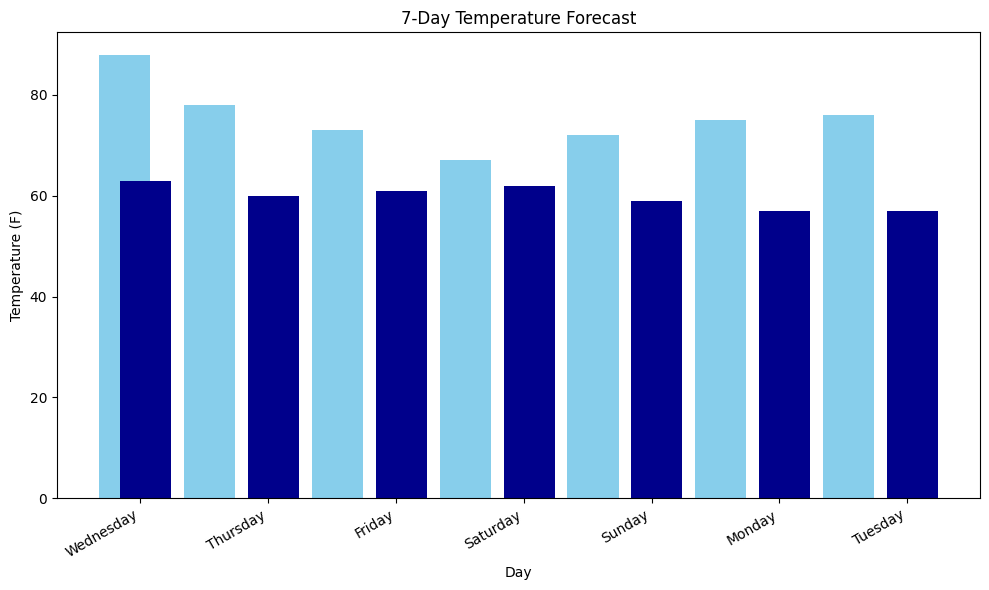

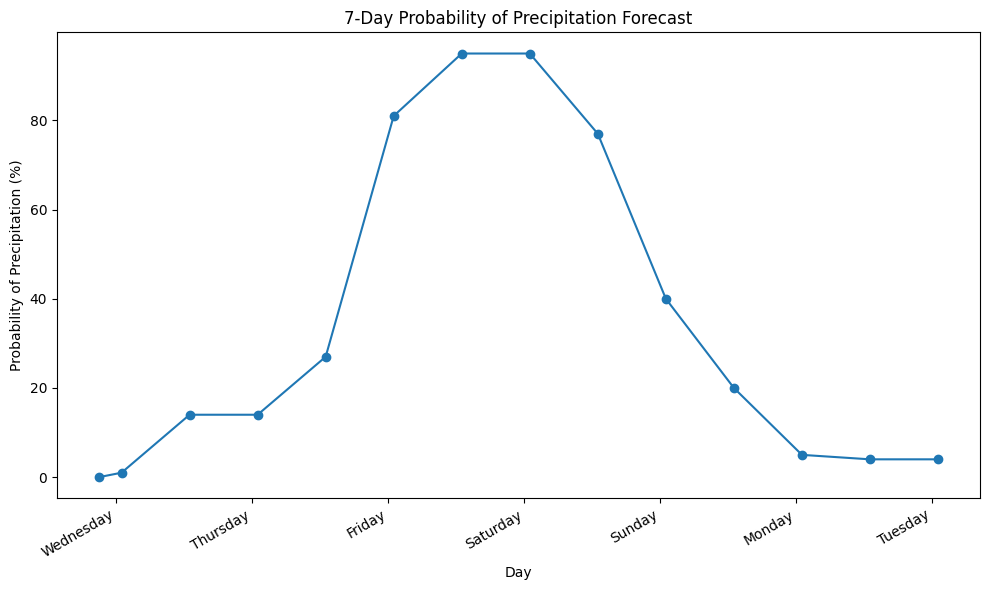

In [ ]:
# 7-day temperature bar graph ------------------------------------------------

import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.dates as mdates

if weather_data_result and 'forecast' in weather_data_result:
    forecast_periods = weather_data_result['forecast']['properties']['periods']

    if not forecast_periods:
        print("7-day forecast data not available for visualization.")
    else:
        # extract times, temperatures, and daytime status for each period
        times = [datetime.fromisoformat(period['startTime']) for period in forecast_periods]
        temperatures = [period['temperature'] for period in forecast_periods]
        is_daytime = [period['isDaytime'] for period in forecast_periods]

        # eetermine the unit
        temp_unit = forecast_periods[0].get('temperatureUnit', '')

        # define colors for day and night
        colors = ['skyblue' if day else 'darkblue' for day in is_daytime]

        plt.figure(figsize=(10, 6))
        # plot bars with different colors based on daytime status
        plt.bar(times, temperatures, width=0.4, color=colors)
        plt.xlabel("Day")
        plt.ylabel(f"Temperature ({temp_unit})")
        plt.title("7-Day Temperature Forecast")

        # format the x-axis to show days of the week
        ax = plt.gca()
        formatter = mdates.DateFormatter('%A')
        ax.xaxis.set_major_formatter(formatter)

        # set tick locations (one tick per day)
        ax.xaxis.set_major_locator(mdates.DayLocator())


        plt.gcf().autofmt_xdate() # auto-format to prevent labels overlapping

        plt.tight_layout()
        plt.show()
else:
    print("7-day forecast data not available for visualization.")


# 7-day precipitation probability line graph ---------------------------------

import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.dates as mdates

if weather_data_result and 'forecast' in weather_data_result:
    forecast_periods = weather_data_result['forecast']['properties']['periods']

    if not forecast_periods:
        print("7-day forecast data not available for visualization.")
    else:
        # extract times and probability of precipitation for each period
        times = [datetime.fromisoformat(period['startTime']) for period in forecast_periods]
        # extract probability of precipitation, handling potential None values
        precipitation_probs = [period.get('probabilityOfPrecipitation', {}).get('value', 0) for period in forecast_periods]

        plt.figure(figsize=(10, 6))
        plt.plot(times, precipitation_probs, marker='o')
        plt.xlabel("Day")
        plt.ylabel("Probability of Precipitation (%)")
        plt.title("7-Day Probability of Precipitation Forecast")

        # format the x-axis to show days of the week
        ax = plt.gca()
        formatter = mdates.DateFormatter('%A')
        ax.xaxis.set_major_formatter(formatter)

        # set tick locations (one tick per day)
        ax.xaxis.set_major_locator(mdates.DayLocator())


        plt.gcf().autofmt_xdate() # auto-format to prevent labels overlapping

        plt.tight_layout()
        plt.show()
else:
    print("7-day forecast data not available for visualization.")

#### 7-Day Container +Alerts

In [ ]:
# 7-day forecast container

import json
from datetime import datetime, timezone

if weather_data_result and 'forecast' in weather_data_result:
    forecast_periods = weather_data_result['forecast']['properties']['periods']
    print("--- 7-Day Forecast ---")

    # Print the total number of active weather alerts found
    if parsed_alerts:
        print(f"Total active weather alerts found for {user_location}: {len(parsed_alerts)}")
    else:
        print(f"No active weather alerts found for {user_location}.")

    for period in forecast_periods:
        # convert period times to datetime objects (assuming ISO 8601 format)
        start_time = datetime.fromisoformat(period['startTime'])
        end_time = datetime.fromisoformat(period['endTime'])

        print(f"\n{period['name']}:")
        print(f"  Temperature: {period.get('temperature')}°{period.get('temperatureUnit', '')}")
        print(f"  Short Forecast: {period.get('shortForecast', 'N/A')}")
        print(f"  Detailed Forecast: {period.get('detailedForecast', 'N/A')}")
        print(f"  Wind Speed: {period.get('windSpeed', 'N/A')}")
        print(f"  Wind Direction: {period.get('windDirection', 'N/A')}")

        # include probability of precipitation
        if period.get('probabilityOfPrecipitation') and period['probabilityOfPrecipitation'].get('value') is not None:
             print(f"  Probability of Precipitation: {period['probabilityOfPrecipitation']['value']}%")

        # check for relevant active alerts within forecast period
        relevant_alerts = []
        if parsed_alerts:
            for alert in parsed_alerts:
                alert_effective = datetime.fromisoformat(alert.get('effective')) if alert.get('effective') else None
                alert_expires = datetime.fromisoformat(alert.get('expires')) if alert.get('expires') else None

                # check if alert times overlap with the forecast period
                if alert_effective and alert_expires:
                    # an alert is relevant if it starts before or during the period and ends after or during the period
                    if (alert_effective <= end_time and alert_expires >= start_time):
                         relevant_alerts.append(alert)
                # alert with no explicit end time
                elif alert_effective and not alert_expires:
                     if alert_effective <= end_time:
                          relevant_alerts.append(alert)
                # alert with no explicit start time (uncommon)
                elif not alert_effective and alert_expires:
                     if alert_expires >= start_time:
                           relevant_alerts.append(alert)
                # alert with no effective or expires time
                else:
                     pass


        if relevant_alerts:
            print("  Active Alerts:")
            for rel_alert in relevant_alerts:
                print(f"    - Event: {rel_alert.get('event', 'N/A')}")
                print(f"      Headline: {rel_alert.get('headline', 'N/A')}")

    # save 7-day forecast data to JSON file
    forecast_output_filename = "noaa_7day_forecast.json"
    try:
        with open(forecast_output_filename, 'w') as f:
            json.dump(forecast_periods, f, indent=4)
        print(f"\n7-day forecast data saved to {forecast_output_filename}")
    except Exception as e:
        print(f"\nError saving 7-day forecast data to JSON: {e}")

else:
    print("Forecast data not available.")

--- 7-Day Forecast ---
Total active weather alerts found for seattle: 14

This Afternoon:
  Temperature: 88°F
  Short Forecast: Sunny
  Detailed Forecast: Sunny, with a high near 88. North northwest wind around 7 mph.
  Wind Speed: 7 mph
  Wind Direction: NNW
  Probability of Precipitation: 0%
  Active Alerts:
    - Event: Red Flag Warning
      Headline: Red Flag Warning issued August 12 at 2:25PM PDT until August 13 at 9:00PM PDT by NWS Spokane WA
    - Event: Extreme Heat Warning
      Headline: Extreme Heat Warning issued August 12 at 2:23PM PDT until August 12 at 10:00PM PDT by NWS Portland OR
    - Event: Heat Advisory
      Headline: Heat Advisory issued August 12 at 2:23PM PDT until August 12 at 10:00PM PDT by NWS Portland OR
    - Event: Wind Advisory
      Headline: Wind Advisory issued August 12 at 1:20PM PDT until August 13 at 8:00PM PDT by NWS Pendleton OR
    - Event: Extreme Heat Warning
      Headline: Extreme Heat Warning issued August 12 at 1:20PM PDT until August 12 

#### Alerts Container


In [ ]:
# active weather alerts container

# iterate through the parsed alerts
if parsed_alerts:
    print(f"--- Active Weather Alerts for {user_location} ---")
    for alert in parsed_alerts:
        print(f"\nEvent: {alert.get('event', 'N/A')}")
        print(f"Headline: {alert.get('headline', 'N/A')}")
        print(f"Description: {alert.get('description', 'N/A')}")
        print(f"Effective: {alert.get('effective', 'N/A')}")
        print(f"Expires: {alert.get('expires', 'N/A')}")
        print("-" * 20) # separator for clarity
else:
    print(f"No active weather alerts found for {user_location}.")

--- Active Weather Alerts for seattle ---

Event: Red Flag Warning
Headline: Red Flag Warning issued August 12 at 2:25PM PDT until August 13 at 9:00PM PDT by NWS Spokane WA
Description: The National Weather Service in Spokane has issued a Red Flag
Warning for wind and low relative humidity, which is in effect
from noon to 9 PM PDT Wednesday. The Fire Weather Watch is no
longer in effect.

* Affected Area: Foothills of Northeast Washington (Zone 701),
Colville Reservation (Zone 702), Okanogan Valley (Zone 703),
Methow Valley (Zone 704), Foothills of Central Washington
Cascades (Zone 705), Waterville Plateau (Zone 706), Western
Columbia Basin (Zone 707), Eastern Columbia Basin  -Palouse  -
Spokane Area (Zone 708) and Lower Palouse  -Snake River (Zone
709).

* Winds: West 15 to 25 mph with gusts up to 35 mph.

* Relative Humidities: 13 to 25 percent.

* Impacts: Rapid fire spread is likely with any new or existing
fires.
Effective: 2025-08-12T14:25:00-07:00
Expires: 2025-08-13T06:00:00-07

#### Air Quality Graph

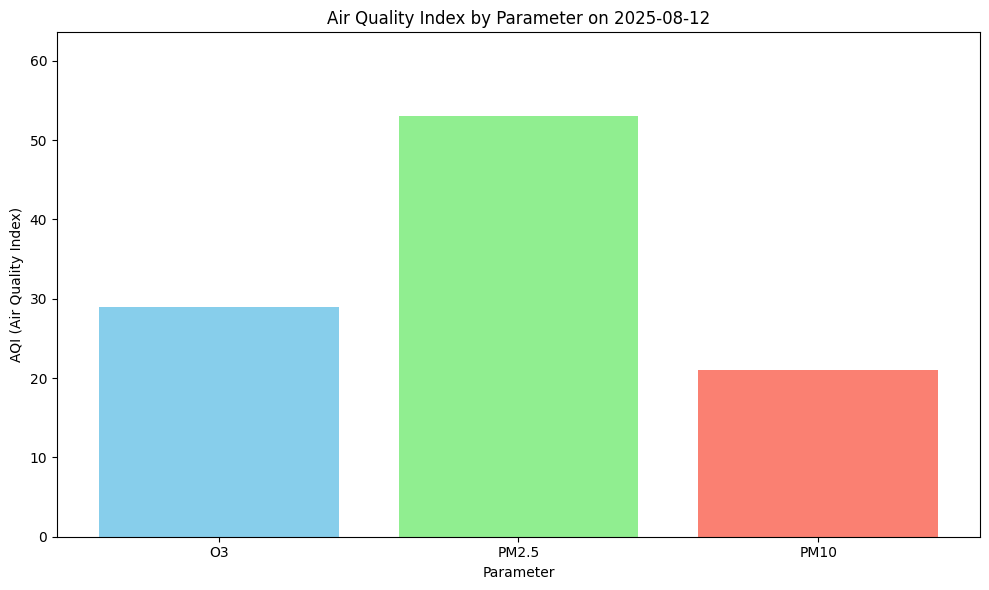

In [ ]:
# AQ (air quality) graph

import matplotlib.pyplot as plt
import pandas as pd

if aq_data:
    # convert list of dictionaries to a pandas DataFrame for easier handling
    aq_df = pd.DataFrame(aq_data)

    if not aq_df.empty:
      # extract date from the first entry (assuming all entries have same date)
      observation_date = aq_df['DateObserved'].iloc[0] if 'DateObserved' in aq_df.columns else "Unknown Date"

      # create a bar chart for AQI by Parameter
      plt.figure(figsize=(10, 6))
      plt.bar(aq_df['ParameterName'], aq_df['AQI'], color=['skyblue', 'lightgreen', 'salmon'])
      plt.xlabel("Parameter")
      plt.ylabel("AQI (Air Quality Index)")
      # add the date to the title
      plt.title(f"Air Quality Index by Parameter on {observation_date}")
      plt.ylim(0, aq_df['AQI'].max() * 1.2) # set y-axis limit a bit above the max AQI
      plt.tight_layout()
      plt.show()
    else:
      print("Air quality data is empty, cannot create visualizations.")
else:
  print("Air quality data not available for visualization.")

#### Air Quality Container

In [ ]:
# air quality container

if aq_data:
    print("--- Air Quality Data ---")
    for entry in aq_data:
        print(f"\nDate Observed: {entry.get('DateObserved', 'N/A')}")
        print(f"Hour Observed: {entry.get('HourObserved', 'N/A')} {entry.get('LocalTimeZone', 'N/A')}")
        print(f"Reporting Area: {entry.get('ReportingArea', 'N/A')}")
        print(f"Parameter Name: {entry.get('ParameterName', 'N/A')}")
        print(f"AQI: {entry.get('AQI', 'N/A')}")
        # access the Name from the Category dictionary
        category_name = entry.get('Category', {}).get('Name', 'N/A')
        print(f"Category: {category_name}")
        print("-" * 20) # separator for clarity
else:
    print("Air quality data not available.")

--- Air Quality Data ---

Date Observed: 2025-08-12
Hour Observed: 13 PST
Reporting Area: Seattle-Bellevue-Kent Valley
Parameter Name: O3
AQI: 29
Category: Good
--------------------

Date Observed: 2025-08-12
Hour Observed: 13 PST
Reporting Area: Seattle-Bellevue-Kent Valley
Parameter Name: PM2.5
AQI: 53
Category: Moderate
--------------------

Date Observed: 2025-08-12
Hour Observed: 13 PST
Reporting Area: Seattle-Bellevue-Kent Valley
Parameter Name: PM10
AQI: 21
Category: Good
--------------------


In [ ]:
# source: https://opendap.co-ops.nos.noaa.gov/axis/
# different SOAP (Simple Object Access Protocol) web services that contains sample requests, sample responses and sample Java Client code



In [ ]:
# metadata sources:
# https://opendap.co-ops.nos.noaa.gov/
# https://opendap.co-ops.nos.noaa.gov/ioos-dif-sos/
# This is CO-OPS' implementation of NOAA's (IOOS) Sensor Observational Service (SOS). CO-OPS SOS web services provide data retrieval of the latest observations and time series, for a "collection" of stations.


In [ ]:
# Access water level predictions from CO-OPS Sensor Observation Service (SOS)

import requests
import pandas as pd
from io import StringIO

# CO-OPS Sensor Observation Service (SOS) URL
sos_url = "https://opendap.co-ops.nos.noaa.gov/ioos-dif-sos/SOS"

# Base URL with service, request, version, and observedProperty
# The observedProperty 'sea_surface_height_amplitude_due_to_equilibrium_ocean_tide' is from the provided Java snippet
base_url = f"{sos_url}?service=SOS&request=GetObservation&version=1.0.0&observedProperty=sea_surface_height_amplitude_due_to_equilibrium_ocean_tide"

# Parameters based on the provided Java snippet
# NOTE: stationsIds and dates are hardcoded here as examples from the Java code.
# You might want to make these dynamic based on user input or other data in your notebook.
stations_ids = ["8454000", "8454049"]
begin_date = "2012-06-01"
end_date = "2012-08-20"
datum = "MSL"  # Datum options: MHHW, MHW, MLLW, MLW, MSL, MTL, NAVD, STND, also can be null
unit = "Feet" # Data unit options: Meters, Feet, also can be null
response_format = "csv" # Response format options: csv, tsv, xml, kml

# Construct the full API URL
# Note: The SOS API uses different parameter names for station, begin_date, end_date compared to the datagetter API
# Based on typical SOS GetObservation requests, these are often 'station', 'eventTime', etc.
# However, the provided Java snippet uses dates as part of the query string, and stationsIds as an array.
# A common way to handle multiple stations in SOS is to include them in the 'offering' or make multiple requests.
# Let's try constructing a URL that includes station IDs and dates in a common SOS query format.
# A more standard SOS query for a time range and multiple stations might look like this:
# observedProperty=water_surface_height_above_reference_datum&offering=urn:ioos:station:NOAA.NOS.CO-OPS:8454000,urn:ioos:station:NOAA.NOS.CO-OPS:8454049&eventTime=2012-06-01T00:00:00Z/2012-08-20T23:59:59Z&responseFormat=text/csv

# Let's adapt the URL construction based on a more standard SOS GetObservation request for a time series.
# We'll use 'water_surface_height_above_reference_datum' as a common observed property for water level.
# The 'offering' parameter is typically used to specify stations and networks.
# The 'eventTime' parameter specifies the time range in ISO 8601 format.

# Construct the offering string for multiple stations
offering_string = ",".join([f"urn:ioos:station:NOAA.NOS.CO-OPS:{sid}" for sid in stations_ids])

# Construct the eventTime string in ISO 8601 format (assuming start of begin_date and end of end_date)
# The SOS standard often requires timezone information, using 'Z' for UTC is common.
event_time_string = f"{begin_date}T00:00:00Z/{end_date}T23:59:59Z"

# Construct the full API URL with standard SOS parameters
# Including datum and unit might require additional parameters or be part of the response format
# Let's build the URL with the core parameters and the requested response format.
api_url = (
    f"{sos_url}?service=SOS&request=GetObservation&version=1.0.0"
    f"&observedProperty=water_surface_height_above_reference_datum" # Using a common water level property
    f"&offering={offering_string}"
    f"&eventTime={event_time_string}"
    f"&responseFormat=text/{response_format}"
)

# Add datum and unit if specified (these might not be standard SOS parameters this way,
# but we'll include them if the API supports them)
if datum:
    api_url += f"&datum={datum}"
if unit:
    api_url += f"&unit={unit}"


print(f"Fetching data from: {api_url}")

# Make the HTTP GET request
try:
    response = requests.get(api_url)

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        print("Data fetched successfully.")

        # Read the content into a pandas DataFrame if the format is CSV
        if response_format.lower() == 'csv':
            try:
                # Use StringIO to treat the text content as a file
                sos_data_df = pd.read_csv(StringIO(response.text))
                print("Data parsed into DataFrame.")
                # Display the first few rows of the DataFrame
                display(sos_data_df.head())
            except Exception as e:
                print(f"Error parsing CSV data: {e}")
                sos_data_df = None
        else:
            # For other formats, just print the text content
            print("Fetched data (non-CSV format):")
            print(response.text[:500]) # Print first 500 characters to avoid flooding output
            sos_data_df = None # DataFrame is not created for non-CSV formats

    else:
        print(f"Error fetching data: Status code {response.status_code}")
        print(f"Response content:\n{response.text}") # Print response content for debugging
        sos_data_df = None # DataFrame is not created if fetch fails

except requests.exceptions.RequestException as e:
    print(f"Error during data request: {e}")
    sos_data_df = None # DataFrame is not created if request fails

# The fetched data (if CSV) is in sos_data_df DataFrame
# If not CSV, the raw text is printed and sos_data_df is None

Fetching data from: https://opendap.co-ops.nos.noaa.gov/ioos-dif-sos/SOS?service=SOS&request=GetObservation&version=1.0.0&observedProperty=water_surface_height_above_reference_datum&offering=urn:ioos:station:NOAA.NOS.CO-OPS:8454000,urn:ioos:station:NOAA.NOS.CO-OPS:8454049&eventTime=2012-06-01T00:00:00Z/2012-08-20T23:59:59Z&responseFormat=text/csv&datum=MSL&unit=Feet
Data fetched successfully.
Data parsed into DataFrame.


,"<?xml version=""1.0"" encoding=""UTF-8""?>"
0,"<ExceptionReport xmlns=""http://www.opengis.net..."
1,"<Exception exceptionCode=""InvalidParameterVa..."
2,<ExceptionText>The station ID of the param...
3,</Exception>
4,"<Exception exceptionCode=""InvalidParameterVa..."


In [ ]:
# Access water level observations from CO-OPS Sensor Observation Service (SOS)

import requests
import pandas as pd
from io import StringIO

# CO-OPS Sensor Observation Service (SOS) URL
sos_url = "https://opendap.co-ops.nos.noaa.gov/ioos-dif-sos/SOS"

# Parameters based on the provided information
# The observedProperty is water_surface_height_above_reference_datum
observed_property = "water_surface_height_above_reference_datum"

# Station Ids
stations_ids = ["1611400", "8311062", "8454049", "9034052", "9044020"]

# Begin date and end date for requested data
begin_date = "2011-11-30"
end_date = "2012-01-10"

# Datum options: IGLD, MHHW, MHW, MLLW, MLW, MSL, MTL, NAVD, STND, also can be null
datum = "" # Empty string for null

# Response format options: csv, tsv, xml, kml
response_format = "csv"

# Construct the offering string for multiple stations
# SOS typically uses URNs for stations in the 'offering' parameter
offering_string = ",".join([f"urn:ioos:station:NOAA.NOS.CO-OPS:{sid}" for sid in stations_ids])

# Construct the eventTime string in ISO 8601 format (assuming start of begin_date and end of end_date)
# The SOS standard often requires timezone information, using 'Z' for UTC is common.
event_time_string = f"{begin_date}T00:00:00Z/{end_date}T23:59:59Z"

# Construct the full API URL with standard SOS parameters
api_url = (
    f"{sos_url}?service=SOS&request=GetObservation&version=1.0.0"
    f"&observedProperty={observed_property}"
    f"&offering={offering_string}"
    f"&eventTime={event_time_string}"
    f"&responseFormat=text/{response_format}"
)

# Add datum if specified and not null
if datum:
    api_url += f"&datum={datum}"

print(f"Fetching water level observations from: {api_url}")

# Make the HTTP GET request
try:
    response = requests.get(api_url)

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        print("Data fetched successfully.")

        # Read the content into a pandas DataFrame if the format is CSV
        if response_format.lower() == 'csv':
            try:
                # Use StringIO to treat the text content as a file
                # The CSV might have metadata lines at the beginning, need to handle that.
                # Let's try reading directly first, and if that fails, inspect the content.
                sos_obs_data_df = pd.read_csv(StringIO(response.text), comment='#') # Use comment to skip lines starting with #
                print("Water level observations parsed into DataFrame.")
                # Display the first few rows of the DataFrame
                display(sos_obs_data_df.head())
            except Exception as e:
                print(f"Error parsing CSV data: {e}")
                print("Response content head:")
                print(response.text[:500]) # Print head of content for debugging
                sos_obs_data_df = None # DataFrame is not created if parsing fails
        else:
            # For other formats, just print the text content
            print("Fetched data (non-CSV format):")
            print(response.text[:500]) # Print first 500 characters to avoid flooding output
            sos_obs_data_df = None # DataFrame is not created for non-CSV formats

    else:
        print(f"Error fetching data: Status code {response.status_code}")
        print(f"Response content:\n{response.text}") # Print response content for debugging
        sos_obs_data_df = None # DataFrame is not created if fetch fails

except requests.exceptions.RequestException as e:
    print(f"Error during data request: {e}")
    sos_obs_data_df = None # DataFrame is not created if request fails

# The fetched data (if CSV) is in sos_obs_data_df DataFrame
# If not CSV or parsing fails, sos_obs_data_df is None

Fetching water level observations from: https://opendap.co-ops.nos.noaa.gov/ioos-dif-sos/SOS?service=SOS&request=GetObservation&version=1.0.0&observedProperty=water_surface_height_above_reference_datum&offering=urn:ioos:station:NOAA.NOS.CO-OPS:1611400,urn:ioos:station:NOAA.NOS.CO-OPS:8311062,urn:ioos:station:NOAA.NOS.CO-OPS:8454049,urn:ioos:station:NOAA.NOS.CO-OPS:9034052,urn:ioos:station:NOAA.NOS.CO-OPS:9044020&eventTime=2011-11-30T00:00:00Z/2012-01-10T23:59:59Z&responseFormat=text/csv
Data fetched successfully.
Water level observations parsed into DataFrame.


,"<?xml version=""1.0"" encoding=""UTF-8""?>"
0,"<ExceptionReport xmlns=""http://www.opengis.net..."
1,"<Exception exceptionCode=""InvalidParameterVa..."
2,<ExceptionText>The station ID of the param...
3,</Exception>
4,"<Exception exceptionCode=""InvalidParameterVa..."


In [ ]:
# Access Meteorological Observations from CO-OPS Sensor Observation Service (SOS)
# access to multiple years of meteorological & ancillary data from multiple stations

import requests
import pandas as pd
from io import StringIO
from datetime import datetime, timedelta

# CO-OPS Sensor Observation Service (SOS) URL
sos_url = "https://opendap.co-ops.nos.noaa.gov/ioos-dif-sos/SOS"

# Parameters based on the provided information
# Observed properties
observed_properties = ["air_temperature", "winds", "rain_fall"]

# Station Ids
stations_ids = ["8454049", "8637689", "9754228", "9759394"]

# Begin date and end date for requested data
begin_date_str = "2011-12-01"
end_date_str = "2012-03-21"

# Response format options: csv, tsv, xml, kml
response_format = "csv"

# Dictionary to store DataFrames for each observed property and station combination
met_data_dfs = {}

# Construct the eventTime string in ISO 8601 format
# The SOS standard often requires timezone information, using 'Z' for UTC is common.
event_time_string = f"{begin_date_str}T00:00:00Z/{end_date_str}T23:59:59Z"

# Iterate through observed properties and stations to fetch data
for prop in observed_properties:
    for station_id in stations_ids:
        # Construct the offering string for the current station
        offering_string = f"urn:ioos:station:NOAA.NOS.CO-OPS:{station_id}"

        # Construct the full API URL
        api_url = (
            f"{sos_url}?service=SOS&request=GetObservation&version=1.0.0"
            f"&observedProperty={prop}"
            f"&offering={offering_string}"
            f"&eventTime={event_time_string}"
            f"&responseFormat=text/{response_format}"
        )

        print(f"\nFetching {prop} data for station {station_id} from: {api_url}")

        # Make the HTTP GET request
        try:
            response = requests.get(api_url)

            # Check if the request was successful (status code 200)
            if response.status_code == 200:
                print("Data fetched successfully.")

                # Read the content into a pandas DataFrame if the format is CSV
                if response_format.lower() == 'csv':
                    try:
                        # Use StringIO to treat the text content as a file
                        # Use comment to skip lines starting with #
                        df = pd.read_csv(StringIO(response.text), comment='#')

                        # Store the DataFrame in the dictionary using a composite key
                        met_data_dfs[f"{prop}_{station_id}"] = df
                        print(f"{prop} data for station {station_id} parsed into DataFrame.")

                    except Exception as e:
                        print(f"Error parsing CSV data for {prop} at station {station_id}: {e}")
                        print("Response content head:")
                        print(response.text[:500]) # Print head of content for debugging

                else:
                    # For other formats, just print the text content and indicate no DataFrame
                    print(f"Fetched data for {prop} at station {station_id} (non-CSV format):")
                    print(response.text[:500]) # Print first 500 characters
            else:
                print(f"Error fetching data for {prop} at station {station_id}: Status code {response.status_code}")
                print(f"Response content:\n{response.text}") # Print response content for debugging

        except requests.exceptions.RequestException as e:
            print(f"Error during data request for {prop} at station {station_id}: {e}")

# After the loop, met_data_dfs dictionary contains DataFrames for successful fetches
# You can now access and process the DataFrames from met_data_dfs
if met_data_dfs:
    print("\n--- Summary of Fetched Meteorological Data ---")
    for key, df in met_data_dfs.items():
        print(f"DataFrame for {key}: {len(df)} rows")
        # Optional: Display head of each DataFrame
        # print(df.head())
else:
    print("\nNo meteorological data could be fetched for the specified parameters and stations.")


Fetching air_temperature data for station 8454049 from: https://opendap.co-ops.nos.noaa.gov/ioos-dif-sos/SOS?service=SOS&request=GetObservation&version=1.0.0&observedProperty=air_temperature&offering=urn:ioos:station:NOAA.NOS.CO-OPS:8454049&eventTime=2011-12-01T00:00:00Z/2012-03-21T23:59:59Z&responseFormat=text/csv
Data fetched successfully.
air_temperature data for station 8454049 parsed into DataFrame.

Fetching air_temperature data for station 8637689 from: https://opendap.co-ops.nos.noaa.gov/ioos-dif-sos/SOS?service=SOS&request=GetObservation&version=1.0.0&observedProperty=air_temperature&offering=urn:ioos:station:NOAA.NOS.CO-OPS:8637689&eventTime=2011-12-01T00:00:00Z/2012-03-21T23:59:59Z&responseFormat=text/csv
Data fetched successfully.
air_temperature data for station 8637689 parsed into DataFrame.

Fetching air_temperature data for station 9754228 from: https://opendap.co-ops.nos.noaa.gov/ioos-dif-sos/SOS?service=SOS&request=GetObservation&version=1.0.0&observedProperty=air_te

In [ ]:
# Define target observed properties and fetch data from the nearest CO-OPS station

import requests
import pandas as pd
from io import StringIO
from datetime import datetime, timedelta

# Ensure nearest_coops_station is available
if 'nearest_coops_station' not in globals() or not nearest_coops_station or 'id' not in nearest_coops_station:
    print("Nearest CO-OPS station information is not available. Cannot fetch data for observed properties.")
else:
    station_id_num = nearest_coops_station['id']
    print(f"Fetching data for observed properties from nearest station: {nearest_coops_station.get('name', station_id_num)} (ID: {station_id_num})")

    # Define the list of target observed properties
    observed_properties = [
        'air_temperature',
        'air_pressure',
        'water_electrical_conductivity',
        'sea_water_speed_and_direction', # Grouped wind speed and direction
        'sea_water_salinity',
        'water_surface_height',
        'sea_water_temperature',
        'wind_speed_and_direction', # Grouped wind speed and direction
        'relative_humidity',
        'rain_fall',
        'visibility'
    ]

    # Dictionary to store fetched data for each property
    coops_observed_data = {}

    # Define a suitable recent date range (e.g., last 24 hours)
    end_time = datetime.utcnow()
    begin_time = end_time - timedelta(days=1) # Fetch data for the last 24 hours
    # Format the date range in ISO 8601 format with Z for UTC
    event_time_string = f'{begin_time.isoformat()}Z/{end_time.isoformat()}Z'


    # Iterate through observed properties and fetch data
    for prop in observed_properties:
        print(f"\nAttempting to fetch data for: {prop}")

        # Base parameters for the SOS GetObservation request
        params = {
            'service': 'SOS',
            'request': 'GetObservation',
            'version': '1.0.0',
            'observedProperty': prop,
            'offering': f'urn:ioos:station:NOAA.NOS.CO-OPS:{station_id_num}', # Use station ID in offering
            'eventTime': event_time_string,
            'responseFormat': 'text/csv', # Request CSV format
        }

        # Adjust parameters based on property or known endpoints/networks
        if prop == 'water_surface_height':
             params['observedProperty'] = 'water_surface_height_above_reference_datum'
             # params['datum'] = 'MLLW' # Optional datum
             # params['unit'] = 'english' # Optional unit
        elif prop == 'sea_water_speed_and_direction':
             params['observedProperty'] = 'sea_water_speed,direction_of_sea_water_velocity' # Attempt multiple properties
             params['offering'] = f'urn:ioos:network:NOAA.NOS.CO-OPS:CurrentsActive,urn:ioos:station:NOAA.NOS.CO-OPS:{station_id_num}' # Use CurrentsActive network
             # params['unit'] = 'm/s' # Optional unit
        elif prop == 'wind_speed_and_direction':
             params['observedProperty'] = 'wind_speed,wind_from_direction,wind_speed_of_gust' # Attempt multiple properties
             params['offering'] = f'urn:ioos:network:NOAA.NOS.CO-OPS:MetActive,urn:ioos:station:NOAA.NOS.CO-OPS:{station_id_num}' # Use MetActive network
             # params['unit'] = 'm/s' # Optional unit
        elif prop in ['air_temperature', 'air_pressure', 'water_electrical_conductivity',
                      'sea_water_salinity', 'sea_water_temperature', 'relative_humidity',
                      'rain_fall', 'visibility']:
             # These properties are typically under the MetActive network
             params['offering'] = f'urn:ioos:network:NOAA.NOS.CO-OPS:MetActive,urn:ioos:station:NOAA.NOS.CO-OPS:{station_id_num}'
             # Handle potential unit specifications if needed (e.g., Fahrenheit for temperature)
             if prop in ['air_temperature', 'sea_water_temperature']:
                 pass # Add unit parameter if needed: params['unit'] = 'Fahrenheit'


        # Construct the full API URL from base URL and parameters
        # Correcting the URL construction: use requests.get(url, params=params)
        # instead of manually building the query string to avoid issues.
        api_url = sos_url # Use the base SOS URL


        print(f"  Requesting data for {prop} from: {api_url} with params: {params}") # Print URL and params for debugging

        # Make the HTTP GET request
        try:
            # Use the params argument to let requests build the query string correctly
            response = requests.get(api_url, params=params)

            # Check if the request was successful (status code 200)
            if response.status_code == 200:
                print(f"  Data fetched successfully for {prop}.")

                # Process the response based on format (assuming CSV for now)
                if params.get('responseFormat', '').lower() == 'text/csv':
                    try:
                        # Use StringIO to treat the text content as a file
                        # Use comment to skip metadata lines starting with #
                        df = pd.read_csv(StringIO(response.text), comment='#')

                        # Check if the DataFrame is empty or contains an error message
                        if not df.empty and 'ExceptionReport' not in response.text:
                           coops_observed_data[prop] = df # Store DataFrame
                           print(f"  {prop} data parsed into DataFrame ({len(df)} rows).")
                        else:
                           print(f"  No data or error response received for {prop}. Response head:")
                           print(response.text[:200]) # Print head of content for debugging
                           coops_observed_data[prop] = f"No data/Error: {response.text[:200]}" # Store error info

                    except Exception as e:
                        print(f"  Error parsing CSV data for {prop}: {e}")
                        coops_observed_data[prop] = response.text # Store raw text if parsing fails
                        print("  Response content head:")
                        print(response.text[:200]) # Print head of content for debugging
                else:
                    # Store raw text for non-CSV formats
                    coops_observed_data[prop] = response.text
                    print(f"  Fetched raw data for {prop} (non-CSV format).")

            else:
                print(f"  Error fetching data for {prop}: Status code {response.status_code}")
                coops_observed_data[prop] = f"Error: Status code {response.status_code}, Content: {response.text[:200]}" # Store error info
                print(f"  Response content head:\n{response.text[:200]}") # Print head of content for debugging

        except requests.exceptions.RequestException as e:
            print(f"  Error during data request for {prop}: {e}")
            coops_observed_data[prop] = f"Error: Request Exception - {e}" # Store error info

    # Display summary of fetched data
    print("\n--- Summary of Fetched CO-OPS Observed Data from Nearest Station ---")
    if coops_observed_data:
        for prop, data in coops_observed_data.items():
            if isinstance(data, pd.DataFrame):
                print(f"  {prop}: Successfully fetched DataFrame ({len(data)} rows)")
                # Optional: print head of DataFrame
                # display(data.head())
            elif isinstance(data, str) and data.startswith("Error:"):
                 print(f"  {prop}: {data}")
            elif isinstance(data, str) and data.startswith("No data/Error:"):
                 print(f"  {prop}: {data}")
            else:
                print(f"  {prop}: Successfully fetched raw data (type: {type(data)})")
    else:
        print("  No data could be fetched for any of the observed properties.")

# The fetched and processed data is stored in the coops_observed_data dictionary.

Fetching data for observed properties from nearest station: Mona Island (ID: 9759938)

Attempting to fetch data for: air_temperature
  Requesting data for air_temperature from: https://opendap.co-ops.nos.noaa.gov/ioos-dif-sos/SOS with params: {'service': 'SOS', 'request': 'GetObservation', 'version': '1.0.0', 'observedProperty': 'air_temperature', 'offering': 'urn:ioos:network:NOAA.NOS.CO-OPS:MetActive,urn:ioos:station:NOAA.NOS.CO-OPS:9759938', 'eventTime': '2025-08-11T21:42:16.620229Z/2025-08-12T21:42:16.620229Z', 'responseFormat': 'text/csv'}


C:\Users\bmo\AppData\Local\Temp\ipykernel_23692\3267641497.py:34: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  end_time = datetime.utcnow()


  Data fetched successfully for air_temperature.
  Error parsing CSV data for air_temperature: Error tokenizing data. C error: Expected 1 fields in line 4, saw 7

  Response content head:
<?xml version="1.0" encoding="UTF-8"?>
<ExceptionReport xmlns="http://www.opengis.net/ows/1.1" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.opengis.net/ows/1.1

Attempting to fetch data for: air_pressure
  Requesting data for air_pressure from: https://opendap.co-ops.nos.noaa.gov/ioos-dif-sos/SOS with params: {'service': 'SOS', 'request': 'GetObservation', 'version': '1.0.0', 'observedProperty': 'air_pressure', 'offering': 'urn:ioos:network:NOAA.NOS.CO-OPS:MetActive,urn:ioos:station:NOAA.NOS.CO-OPS:9759938', 'eventTime': '2025-08-11T21:42:16.620229Z/2025-08-12T21:42:16.620229Z', 'responseFormat': 'text/csv'}
  Data fetched successfully for air_pressure.
  Error parsing CSV data for air_pressure: Error tokenizing data. C error: Expected 1 fields in line 4, saw 7


In [ ]:
from geopy.distance import geodesic

# find nearest stations
if latitude is None or longitude is None:
    print("User location (latitude or longitude) not available. Skipping distance calculation.")
elif 'coops_stations_data' not in globals() or not coops_stations_data:
    print("CO-OPS stations data not available. Skipping distance calculation.")
else:
    # iterate through coops_stations_data list
    for station in coops_stations_data:
        # extract latitude and longitude for each station
        station_lat = station.get('latitude')
        station_lon = station.get('longitude')

        # calculate distance
        if station_lat is not None and station_lon is not None:
            try:
                user_coords = (latitude, longitude)
                station_coords = (station_lat, station_lon)
                distance = geodesic(user_coords, station_coords).miles
            except ValueError:
                # handle potential value error during calculation
                distance = float('inf')
        else:
            distance = float('inf') # assign infinity if coords are missing

        # add a 'distance' key to each station's dictionary
        station['distance'] = distance
    print("Distance to each CO-OPS station calculated.")

# find station with shortest distance to user
if 'coops_stations_data' not in globals() or not coops_stations_data:
    print("CO-OPS station data not available. Cannot find the nearest station.")
else:
    try:
        nearest_coops_station = min(coops_stations_data, key=lambda station: station.get('distance', float('inf')))

        # print the ID, name, and distance of the nearest station
        station_id = nearest_coops_station.get('id', 'N/A')
        station_name = nearest_coops_station.get('name', 'N/A')
        station_distance = nearest_coops_station.get('distance', float('inf'))

        if station_distance != float('inf'):
            print(f"\n------- Nearest CO-OPS station ------- \nStation ID: {station_id}, name: {station_name}, distance: {station_distance:.2f} miles")
        else:
            print("Nearest CO-OPS station found, but distance information is missing.")
    except ValueError:
        print("Could not find the nearest CO-OPS station.")

Distance to each CO-OPS station calculated.

------- Nearest CO-OPS station ------- 
Station ID: 9759938, name: Mona Island, distance: 0.00 miles
